LR=0.01

In [1]:
import sys
sys.path.append("..")

import numpy as np
from train_utils import Trainer, Evaluator, train, train_certified_wm

import torchvision
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms

In [2]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


==> Preparing data..


In [3]:
def watermark_unrelated(new_label=4, count=100):
    np.random.seed(20)
    trainset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True)
    watermarkset = []
    for idx in range(len(trainset)):
        img, label = trainset[idx]
        img = transforms.Resize((32,32))(img)
        img = transforms.ToTensor()(img)
        img = img.repeat(3, 1, 1)
        if idx == 0:
          x = (img.permute(1, 2, 0).numpy()*255).astype(np.uint8)
          #x = x[:,:,0]
          x = Image.fromarray(x)
          display(x)
          print(img.shape)
        img = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))(img)
        label = new_label
        watermarkset.append((img, label))
        if len(watermarkset) == count:
            return watermarkset
def generate_random_trigger(data_path):
    np.random.seed(20)
    adv_trigger_path = os.path.join(data_path, 'with_trigger/trigger_random')
    os.makedirs(adv_trigger_path, exist_ok=True)
    trigger_data = datasets.ImageFolder(os.path.join(data_path, "with_trigger/trigger_clean"))
    writer = csv.writer(open(os.path.join(adv_trigger_path, "labels.csv"), "w"))
    writer.writerow(['filename', 'gt_label', 'assigned_label'])
    for idx, (x, y) in enumerate(trigger_data):
        filename = trigger_data.imgs[idx][0].rsplit('/', 1)[-1]
        final_labels = [i for i in range(len(trigger_data.classes)) if i != y]
        assigned_label = np.random.choice(final_labels)
        save_path = os.path.join(adv_trigger_path, trigger_data.classes[assigned_label])
        os.makedirs(save_path, exist_ok=True)
        x.save(os.path.join(save_path, filename))
        writer.writerow([filename, trigger_data.classes[y], trigger_data.classes[assigned_label]])        

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


def test():
    net = ResNet18().cuda()
    y = net(torch.randn(1, 3, 32, 32).cuda())
    print(y.size())

test()

torch.Size([1, 10])


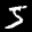

torch.Size([3, 32, 32])


In [5]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/train/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_8020/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_adv/', transform=transform_test)
unrelatedset = watermark_unrelated(count=100)
train_watermark_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

# valloader = torch.utils.data.DataLoader(
#     valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
train_watermark_loader = torch.utils.data.DataLoader(
    train_watermark_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

Random Label Uniform Scheme

In [6]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_rand_lr0.01.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adjusting learning rate of group 0 to 1.0000e-02.
Start Training...


2023-02-15 12:16:45.183599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 12:16:45.256700: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-15 12:16:45.271456: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-15 12:16:45.554122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 0 | Time 28s| Train Loss 1.0689 | Train Acc 68.52| Val Loss 0.762 | Val Acc 76.06| Trigger Loss 1.936 | Trigger Acc 24.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.82it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 1 | Time 56s| Train Loss 0.8246 | Train Acc 71.84| Val Loss 0.772 | Val Acc 74.90| Trigger Loss 1.319 | Trigger Acc 44.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  9.18it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2 | Time 76s| Train Loss 0.7944 | Train Acc 73.37| Val Loss 0.888 | Val Acc 72.53| Trigger Loss 0.742 | Trigger Acc 72.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:10<00:00, 14.85it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 3 | Time 89s| Train Loss 0.8085 | Train Acc 73.83| Val Loss 0.989 | Val Acc 70.76| Trigger Loss 0.413 | Trigger Acc 89.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.96it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 4 | Time 107s| Train Loss 1.0097 | Train Acc 66.88| Val Loss 1.361 | Val Acc 58.61| Trigger Loss 0.520 | Trigger Acc 78.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.88it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 5 | Time 124s| Train Loss 1.3036 | Train Acc 63.01| Val Loss 1.181 | Val Acc 60.18| Trigger Loss 0.610 | Trigger Acc 82.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.41it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 6 | Time 151s| Train Loss 1.0030 | Train Acc 65.91| Val Loss 1.380 | Val Acc 51.03| Trigger Loss 1.545 | Trigger Acc 43.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.46it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 7 | Time 179s| Train Loss 1.0621 | Train Acc 63.99| Val Loss 1.617 | Val Acc 41.94| Trigger Loss 1.817 | Trigger Acc 33.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.78it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 8 | Time 209s| Train Loss 1.2876 | Train Acc 56.07| Val Loss 1.918 | Val Acc 29.80| Trigger Loss 1.911 | Trigger Acc 25.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.80it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 9 | Time 232s| Train Loss 1.4207 | Train Acc 50.89| Val Loss 1.790 | Val Acc 39.82| Trigger Loss 1.313 | Trigger Acc 60.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.28it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 10 | Time 252s| Train Loss 1.3879 | Train Acc 52.85| Val Loss 1.456 | Val Acc 48.99| Trigger Loss 0.647 | Trigger Acc 85.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.97it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 11 | Time 269s| Train Loss 1.3703 | Train Acc 56.74| Val Loss 1.325 | Val Acc 53.05| Trigger Loss 0.504 | Trigger Acc 92.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.32it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 12 | Time 296s| Train Loss 1.1116 | Train Acc 62.20| Val Loss 1.322 | Val Acc 52.58| Trigger Loss 0.615 | Trigger Acc 93.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.20it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 13 | Time 311s| Train Loss 1.1588 | Train Acc 60.89| Val Loss 1.341 | Val Acc 51.79| Trigger Loss 0.739 | Trigger Acc 86.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.25it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 14 | Time 331s| Train Loss 1.1586 | Train Acc 60.41| Val Loss 1.409 | Val Acc 50.20| Trigger Loss 0.679 | Trigger Acc 85.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.71it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 15 | Time 354s| Train Loss 1.1113 | Train Acc 61.76| Val Loss 1.237 | Val Acc 56.00| Trigger Loss 0.374 | Trigger Acc 98.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  9.14it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 16 | Time 374s| Train Loss 0.9586 | Train Acc 66.66| Val Loss 1.262 | Val Acc 56.70| Trigger Loss 0.368 | Trigger Acc 93.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.86it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 17 | Time 392s| Train Loss 0.8911 | Train Acc 68.80| Val Loss 1.037 | Val Acc 63.34| Trigger Loss 0.179 | Trigger Acc 99.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.41it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 18 | Time 419s| Train Loss 0.8924 | Train Acc 69.33| Val Loss 1.028 | Val Acc 63.83| Trigger Loss 0.262 | Trigger Acc 99.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.50it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 19 | Time 446s| Train Loss 0.8991 | Train Acc 69.42| Val Loss 1.102 | Val Acc 61.21| Trigger Loss 0.342 | Trigger Acc 97.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.85it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 20 | Time 476s| Train Loss 0.8993 | Train Acc 69.25| Val Loss 1.093 | Val Acc 62.55| Trigger Loss 0.255 | Trigger Acc 98.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.78it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 21 | Time 499s| Train Loss 0.8700 | Train Acc 69.92| Val Loss 1.002 | Val Acc 65.45| Trigger Loss 0.126 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.19it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 22 | Time 519s| Train Loss 0.8056 | Train Acc 72.09| Val Loss 1.011 | Val Acc 65.81| Trigger Loss 0.204 | Trigger Acc 96.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 16.23it/s]


Adjusting learning rate of group 0 to 2.5000e-03.
Epoch 23 | Time 531s| Train Loss 0.7630 | Train Acc 73.53| Val Loss 0.913 | Val Acc 68.74| Trigger Loss 0.062 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.19it/s]


Adjusting learning rate of group 0 to 2.5000e-03.
Epoch 24 | Time 547s| Train Loss 0.7496 | Train Acc 74.22| Val Loss 0.894 | Val Acc 69.01| Trigger Loss 0.112 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:19<00:00,  8.20it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 25 | Time 569s| Train Loss 0.7364 | Train Acc 74.50| Val Loss 0.890 | Val Acc 68.89| Trigger Loss 0.145 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.78it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 26 | Time 599s| Train Loss 0.7662 | Train Acc 73.66| Val Loss 1.057 | Val Acc 63.98| Trigger Loss 0.248 | Trigger Acc 93.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.73it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 27 | Time 622s| Train Loss 0.7694 | Train Acc 73.41| Val Loss 0.992 | Val Acc 65.43| Trigger Loss 0.191 | Trigger Acc 96.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  9.16it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 28 | Time 642s| Train Loss 0.7520 | Train Acc 74.08| Val Loss 0.947 | Val Acc 67.36| Trigger Loss 0.076 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.91it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 29 | Time 660s| Train Loss 0.7106 | Train Acc 75.33| Val Loss 0.858 | Val Acc 70.80| Trigger Loss 0.064 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.46it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 30 | Time 687s| Train Loss 0.6665 | Train Acc 76.79| Val Loss 0.825 | Val Acc 71.37| Trigger Loss 0.058 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.54it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 31 | Time 714s| Train Loss 0.6612 | Train Acc 77.15| Val Loss 0.816 | Val Acc 71.85| Trigger Loss 0.072 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.89it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 32 | Time 743s| Train Loss 0.6659 | Train Acc 77.11| Val Loss 0.841 | Val Acc 70.99| Trigger Loss 0.066 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.59it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 33 | Time 762s| Train Loss 0.6597 | Train Acc 77.32| Val Loss 0.841 | Val Acc 70.73| Trigger Loss 0.107 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 17.09it/s]


Adjusting learning rate of group 0 to 1.2500e-03.
Epoch 34 | Time 773s| Train Loss 0.6490 | Train Acc 77.52| Val Loss 0.795 | Val Acc 72.19| Trigger Loss 0.054 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 20.42it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 35 | Time 784s| Train Loss 0.6159 | Train Acc 78.66| Val Loss 0.810 | Val Acc 72.57| Trigger Loss 0.044 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.62it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 36 | Time 810s| Train Loss 0.6007 | Train Acc 79.30| Val Loss 0.779 | Val Acc 73.48| Trigger Loss 0.055 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.47it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 37 | Time 838s| Train Loss 0.5916 | Train Acc 79.71| Val Loss 0.761 | Val Acc 73.81| Trigger Loss 0.054 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.78it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 38 | Time 868s| Train Loss 0.6123 | Train Acc 78.88| Val Loss 0.791 | Val Acc 72.78| Trigger Loss 0.079 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.74it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 39 | Time 892s| Train Loss 0.6154 | Train Acc 78.91| Val Loss 0.864 | Val Acc 71.18| Trigger Loss 0.196 | Trigger Acc 96.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.27it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 40 | Time 912s| Train Loss 0.5894 | Train Acc 79.65| Val Loss 0.765 | Val Acc 74.57| Trigger Loss 0.041 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.98it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 41 | Time 929s| Train Loss 0.5580 | Train Acc 80.68| Val Loss 0.709 | Val Acc 75.72| Trigger Loss 0.026 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.48it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 42 | Time 956s| Train Loss 0.5425 | Train Acc 81.24| Val Loss 0.715 | Val Acc 75.97| Trigger Loss 0.030 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.40it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 43 | Time 984s| Train Loss 0.5381 | Train Acc 81.29| Val Loss 0.703 | Val Acc 75.80| Trigger Loss 0.032 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.95it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 44 | Time 1001s| Train Loss 0.5418 | Train Acc 81.27| Val Loss 0.771 | Val Acc 74.51| Trigger Loss 0.063 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.27it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 45 | Time 1016s| Train Loss 0.5340 | Train Acc 81.60| Val Loss 0.716 | Val Acc 75.57| Trigger Loss 0.038 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  9.16it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 46 | Time 1036s| Train Loss 0.5463 | Train Acc 81.06| Val Loss 0.745 | Val Acc 75.14| Trigger Loss 0.039 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.90it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 47 | Time 1054s| Train Loss 0.5114 | Train Acc 82.43| Val Loss 0.700 | Val Acc 76.16| Trigger Loss 0.036 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.41it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 48 | Time 1082s| Train Loss 0.5022 | Train Acc 82.59| Val Loss 0.677 | Val Acc 76.67| Trigger Loss 0.026 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.48it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 49 | Time 1109s| Train Loss 0.4952 | Train Acc 82.77| Val Loss 0.667 | Val Acc 76.97| Trigger Loss 0.025 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.81it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 50 | Time 1139s| Train Loss 0.4930 | Train Acc 82.76| Val Loss 0.697 | Val Acc 76.23| Trigger Loss 0.033 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.78it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 51 | Time 1163s| Train Loss 0.4878 | Train Acc 82.99| Val Loss 0.657 | Val Acc 77.71| Trigger Loss 0.025 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.30it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 52 | Time 1183s| Train Loss 0.4829 | Train Acc 83.23| Val Loss 0.655 | Val Acc 78.15| Trigger Loss 0.023 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 11.06it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 53 | Time 1200s| Train Loss 0.4581 | Train Acc 84.29| Val Loss 0.657 | Val Acc 77.96| Trigger Loss 0.014 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  8.88it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 54 | Time 1220s| Train Loss 0.4608 | Train Acc 83.96| Val Loss 0.638 | Val Acc 78.27| Trigger Loss 0.018 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.18it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 55 | Time 1236s| Train Loss 0.4504 | Train Acc 84.40| Val Loss 0.634 | Val Acc 78.39| Trigger Loss 0.018 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.29it/s]


Adjusting learning rate of group 0 to 3.1250e-04.
Epoch 56 | Time 1264s| Train Loss 0.4555 | Train Acc 84.22| Val Loss 0.626 | Val Acc 78.71| Trigger Loss 0.030 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.72it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 57 | Time 1288s| Train Loss 0.4535 | Train Acc 84.31| Val Loss 0.686 | Val Acc 77.38| Trigger Loss 0.034 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  9.15it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 58 | Time 1308s| Train Loss 0.4586 | Train Acc 83.94| Val Loss 0.649 | Val Acc 78.08| Trigger Loss 0.016 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.92it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 59 | Time 1326s| Train Loss 0.4383 | Train Acc 84.70| Val Loss 0.622 | Val Acc 79.59| Trigger Loss 0.012 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.41it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 60 | Time 1353s| Train Loss 0.4203 | Train Acc 85.34| Val Loss 0.617 | Val Acc 79.74| Trigger Loss 0.012 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.55it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 61 | Time 1380s| Train Loss 0.4182 | Train Acc 85.36| Val Loss 0.614 | Val Acc 79.76| Trigger Loss 0.013 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.83it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 62 | Time 1410s| Train Loss 0.4200 | Train Acc 85.20| Val Loss 0.614 | Val Acc 79.67| Trigger Loss 0.014 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.71it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 63 | Time 1434s| Train Loss 0.4170 | Train Acc 85.51| Val Loss 0.600 | Val Acc 80.03| Trigger Loss 0.014 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:10<00:00, 14.75it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 64 | Time 1447s| Train Loss 0.4149 | Train Acc 85.54| Val Loss 0.608 | Val Acc 79.73| Trigger Loss 0.011 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 20.37it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 65 | Time 1458s| Train Loss 0.4019 | Train Acc 86.05| Val Loss 0.599 | Val Acc 80.04| Trigger Loss 0.009 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.25it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 66 | Time 1478s| Train Loss 0.3930 | Train Acc 86.24| Val Loss 0.600 | Val Acc 79.99| Trigger Loss 0.010 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.47it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 67 | Time 1505s| Train Loss 0.3908 | Train Acc 86.29| Val Loss 0.599 | Val Acc 79.81| Trigger Loss 0.010 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.77it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 68 | Time 1536s| Train Loss 0.3948 | Train Acc 86.12| Val Loss 0.593 | Val Acc 80.36| Trigger Loss 0.011 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.73it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 69 | Time 1559s| Train Loss 0.3946 | Train Acc 86.00| Val Loss 0.597 | Val Acc 80.11| Trigger Loss 0.012 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.18it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 70 | Time 1580s| Train Loss 0.3877 | Train Acc 86.52| Val Loss 0.583 | Val Acc 80.80| Trigger Loss 0.008 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.98it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 71 | Time 1597s| Train Loss 0.3728 | Train Acc 86.93| Val Loss 0.587 | Val Acc 80.79| Trigger Loss 0.007 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.47it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 72 | Time 1625s| Train Loss 0.3718 | Train Acc 86.90| Val Loss 0.586 | Val Acc 81.01| Trigger Loss 0.007 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.57it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 73 | Time 1652s| Train Loss 0.3667 | Train Acc 87.12| Val Loss 0.586 | Val Acc 80.88| Trigger Loss 0.007 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.40it/s]


Adjusting learning rate of group 0 to 7.8125e-05.
Epoch 74 | Time 1675s| Train Loss 0.3696 | Train Acc 87.06| Val Loss 0.584 | Val Acc 80.98| Trigger Loss 0.007 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:10<00:00, 14.40it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 75 | Time 1689s| Train Loss 0.3678 | Train Acc 86.89| Val Loss 0.579 | Val Acc 81.13| Trigger Loss 0.008 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.68it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 76 | Time 1705s| Train Loss 0.3715 | Train Acc 86.78| Val Loss 0.582 | Val Acc 80.65| Trigger Loss 0.008 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.95it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 77 | Time 1722s| Train Loss 0.3637 | Train Acc 87.19| Val Loss 0.578 | Val Acc 81.26| Trigger Loss 0.006 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.41it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 78 | Time 1750s| Train Loss 0.3564 | Train Acc 87.52| Val Loss 0.578 | Val Acc 81.17| Trigger Loss 0.005 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.47it/s]

Adjusting learning rate of group 0 to 3.9063e-05.


Epoch 79 | Time 1777s| Train Loss 0.3534 | Train Acc 87.57| Val Loss 0.576 | Val Acc 81.29| Trigger Loss 0.006 | Trigger Acc 100.00


{'train_acc': [68.51634534786253,
  71.83570829840737,
  73.36546521374686,
  73.8327745180218,
  66.88181056160938,
  63.01341156747695,
  65.90947191953059,
  63.99203688181056,
  56.068734283319365,
  50.89061190276614,
  52.849958088851636,
  56.739312657166806,
  62.204526404023476,
  60.88642078792959,
  60.4149203688181,
  61.76445934618609,
  66.65968147527242,
  68.79715004191115,
  69.32523051131601,
  69.41533948030177,
  69.25188600167644,
  69.92455993294216,
  72.0850796311819,
  73.53101424979045,
  74.22254819782061,
  74.49706621961441,
  73.66093880972339,
  73.41156747694887,
  74.07795473595976,
  75.33319362950544,
  76.79379715004191,
  77.15004191114836,
  77.11441743503772,
  77.31768650461022,
  77.52095557418274,
  78.65674769488685,
  79.29798826487846,
  79.71081307627828,
  78.88306789606035,
  78.91450125733445,
  79.65213746856664,
  80.68105616093881,
  81.24266554903605,
  81.28667225481978,
  81.26781223805533,
  81.5989103101425,
  81.058256496228,
  

Adversarial Sample Uniform Scheme

In [7]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_adv_lr0.01.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

Adjusting learning rate of group 0 to 1.0000e-02.
Start Training...


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.75it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 0 | Time 26s| Train Loss 0.9615 | Train Acc 70.22| Val Loss 0.691 | Val Acc 77.94| Trigger Loss 1.758 | Trigger Acc 32.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.82it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 1 | Time 54s| Train Loss 0.7682 | Train Acc 73.83| Val Loss 0.752 | Val Acc 76.08| Trigger Loss 1.226 | Trigger Acc 57.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.12it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 2 | Time 83s| Train Loss 0.7355 | Train Acc 76.30| Val Loss 0.766 | Val Acc 75.87| Trigger Loss 0.462 | Trigger Acc 87.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:19<00:00,  8.13it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 3 | Time 106s| Train Loss 0.8123 | Train Acc 73.83| Val Loss 0.883 | Val Acc 73.21| Trigger Loss 0.331 | Trigger Acc 92.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.61it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4 | Time 121s| Train Loss 1.0381 | Train Acc 66.55| Val Loss 1.152 | Val Acc 64.20| Trigger Loss 0.557 | Trigger Acc 82.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 20.24it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 5 | Time 132s| Train Loss 1.2354 | Train Acc 63.57| Val Loss 1.265 | Val Acc 56.82| Trigger Loss 0.354 | Trigger Acc 92.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.17it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 6 | Time 148s| Train Loss 1.0465 | Train Acc 65.37| Val Loss 1.335 | Val Acc 50.93| Trigger Loss 1.569 | Trigger Acc 48.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.47it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 7 | Time 176s| Train Loss 1.1090 | Train Acc 62.51| Val Loss 1.693 | Val Acc 38.37| Trigger Loss 1.999 | Trigger Acc 26.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.77it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8 | Time 206s| Train Loss 1.3798 | Train Acc 52.66| Val Loss 1.919 | Val Acc 29.31| Trigger Loss 1.700 | Trigger Acc 29.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.73it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 9 | Time 229s| Train Loss 1.3899 | Train Acc 51.58| Val Loss 1.883 | Val Acc 31.49| Trigger Loss 1.543 | Trigger Acc 40.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  9.16it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 10 | Time 249s| Train Loss 1.3303 | Train Acc 55.04| Val Loss 1.330 | Val Acc 51.95| Trigger Loss 0.407 | Trigger Acc 95.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.91it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 11 | Time 266s| Train Loss 1.3743 | Train Acc 56.94| Val Loss 1.291 | Val Acc 53.31| Trigger Loss 0.316 | Trigger Acc 99.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.47it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 12 | Time 294s| Train Loss 1.1000 | Train Acc 62.35| Val Loss 1.280 | Val Acc 53.78| Trigger Loss 0.452 | Trigger Acc 98.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.55it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 13 | Time 320s| Train Loss 1.1818 | Train Acc 60.03| Val Loss 1.343 | Val Acc 51.26| Trigger Loss 0.656 | Trigger Acc 89.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.79it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 14 | Time 350s| Train Loss 1.1447 | Train Acc 60.78| Val Loss 1.475 | Val Acc 47.79| Trigger Loss 0.643 | Trigger Acc 81.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:10<00:00, 14.43it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 15 | Time 363s| Train Loss 1.0853 | Train Acc 62.61| Val Loss 1.202 | Val Acc 56.89| Trigger Loss 0.211 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 17.13it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 16 | Time 375s| Train Loss 0.9749 | Train Acc 66.08| Val Loss 1.095 | Val Acc 60.39| Trigger Loss 0.252 | Trigger Acc 97.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.75it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 17 | Time 391s| Train Loss 0.9082 | Train Acc 68.05| Val Loss 1.037 | Val Acc 62.55| Trigger Loss 0.101 | Trigger Acc 99.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.40it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 18 | Time 419s| Train Loss 0.9241 | Train Acc 68.21| Val Loss 1.072 | Val Acc 61.15| Trigger Loss 0.179 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.48it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 19 | Time 446s| Train Loss 0.8865 | Train Acc 69.23| Val Loss 1.086 | Val Acc 60.55| Trigger Loss 0.222 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.77it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 20 | Time 476s| Train Loss 0.9040 | Train Acc 68.55| Val Loss 1.096 | Val Acc 61.46| Trigger Loss 0.260 | Trigger Acc 97.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.75it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 21 | Time 499s| Train Loss 0.8825 | Train Acc 68.99| Val Loss 1.046 | Val Acc 61.82| Trigger Loss 0.367 | Trigger Acc 95.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.28it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 22 | Time 519s| Train Loss 0.8327 | Train Acc 70.74| Val Loss 0.981 | Val Acc 65.44| Trigger Loss 0.055 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.95it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 23 | Time 537s| Train Loss 0.7774 | Train Acc 72.64| Val Loss 0.937 | Val Acc 66.80| Trigger Loss 0.068 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.50it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 24 | Time 564s| Train Loss 0.7628 | Train Acc 73.26| Val Loss 0.938 | Val Acc 66.67| Trigger Loss 0.126 | Trigger Acc 99.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:19<00:00,  7.86it/s]


Adjusting learning rate of group 0 to 2.5000e-03.
Epoch 25 | Time 586s| Train Loss 0.7477 | Train Acc 73.90| Val Loss 0.906 | Val Acc 67.55| Trigger Loss 0.082 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.91it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 26 | Time 603s| Train Loss 0.7742 | Train Acc 73.01| Val Loss 1.283 | Val Acc 60.02| Trigger Loss 0.320 | Trigger Acc 90.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.27it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 27 | Time 623s| Train Loss 0.7665 | Train Acc 73.21| Val Loss 0.951 | Val Acc 66.68| Trigger Loss 0.154 | Trigger Acc 99.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  9.16it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 28 | Time 643s| Train Loss 0.7655 | Train Acc 73.28| Val Loss 0.972 | Val Acc 67.13| Trigger Loss 0.128 | Trigger Acc 97.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.88it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 29 | Time 660s| Train Loss 0.7100 | Train Acc 75.16| Val Loss 0.865 | Val Acc 70.46| Trigger Loss 0.053 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.40it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 30 | Time 688s| Train Loss 0.6791 | Train Acc 76.32| Val Loss 0.828 | Val Acc 71.53| Trigger Loss 0.038 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.45it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 31 | Time 715s| Train Loss 0.6625 | Train Acc 77.02| Val Loss 0.818 | Val Acc 71.56| Trigger Loss 0.042 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.82it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 32 | Time 745s| Train Loss 0.6731 | Train Acc 76.65| Val Loss 0.876 | Val Acc 69.70| Trigger Loss 0.054 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.79it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 33 | Time 768s| Train Loss 0.6609 | Train Acc 77.18| Val Loss 0.884 | Val Acc 70.27| Trigger Loss 0.270 | Trigger Acc 95.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.30it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 34 | Time 788s| Train Loss 0.6534 | Train Acc 77.28| Val Loss 0.833 | Val Acc 72.01| Trigger Loss 0.118 | Trigger Acc 98.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.75it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 35 | Time 806s| Train Loss 0.6124 | Train Acc 78.82| Val Loss 0.762 | Val Acc 73.78| Trigger Loss 0.018 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.60it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 36 | Time 821s| Train Loss 0.6147 | Train Acc 78.75| Val Loss 0.755 | Val Acc 74.37| Trigger Loss 0.048 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.06it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 37 | Time 838s| Train Loss 0.6067 | Train Acc 79.02| Val Loss 0.755 | Val Acc 74.09| Trigger Loss 0.058 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.78it/s]


Adjusting learning rate of group 0 to 1.2500e-03.
Epoch 38 | Time 868s| Train Loss 0.6218 | Train Acc 78.61| Val Loss 0.771 | Val Acc 73.65| Trigger Loss 0.039 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.74it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 39 | Time 891s| Train Loss 0.6193 | Train Acc 78.47| Val Loss 0.836 | Val Acc 71.93| Trigger Loss 0.049 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  9.15it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 40 | Time 911s| Train Loss 0.5957 | Train Acc 79.26| Val Loss 0.732 | Val Acc 74.69| Trigger Loss 0.017 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.92it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 41 | Time 929s| Train Loss 0.5629 | Train Acc 80.44| Val Loss 0.709 | Val Acc 76.07| Trigger Loss 0.015 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.42it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 42 | Time 956s| Train Loss 0.5466 | Train Acc 80.85| Val Loss 0.699 | Val Acc 75.85| Trigger Loss 0.016 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.53it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 43 | Time 984s| Train Loss 0.5373 | Train Acc 81.23| Val Loss 0.695 | Val Acc 76.03| Trigger Loss 0.015 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.85it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 44 | Time 1014s| Train Loss 0.5463 | Train Acc 80.98| Val Loss 0.714 | Val Acc 75.59| Trigger Loss 0.028 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.56it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 45 | Time 1037s| Train Loss 0.5413 | Train Acc 81.17| Val Loss 0.701 | Val Acc 75.91| Trigger Loss 0.039 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 17.17it/s]


Adjusting learning rate of group 0 to 6.2500e-04.
Epoch 46 | Time 1049s| Train Loss 0.5469 | Train Acc 81.10| Val Loss 0.701 | Val Acc 75.99| Trigger Loss 0.028 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 20.20it/s]


Adjusting learning rate of group 0 to 6.2500e-04.
Epoch 47 | Time 1059s| Train Loss 0.5254 | Train Acc 81.61| Val Loss 0.668 | Val Acc 76.88| Trigger Loss 0.010 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.46it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 48 | Time 1084s| Train Loss 0.5116 | Train Acc 82.14| Val Loss 0.667 | Val Acc 77.22| Trigger Loss 0.016 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.46it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 49 | Time 1111s| Train Loss 0.5018 | Train Acc 82.45| Val Loss 0.665 | Val Acc 77.14| Trigger Loss 0.015 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.77it/s]


Adjusting learning rate of group 0 to 3.1250e-04.
Epoch 50 | Time 1142s| Train Loss 0.5022 | Train Acc 82.53| Val Loss 0.659 | Val Acc 77.50| Trigger Loss 0.019 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.73it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 51 | Time 1165s| Train Loss 0.4976 | Train Acc 82.73| Val Loss 0.660 | Val Acc 77.35| Trigger Loss 0.014 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.24it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 52 | Time 1185s| Train Loss 0.4912 | Train Acc 82.83| Val Loss 0.650 | Val Acc 77.68| Trigger Loss 0.017 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.99it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 53 | Time 1203s| Train Loss 0.4699 | Train Acc 83.66| Val Loss 0.638 | Val Acc 78.42| Trigger Loss 0.007 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.46it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 54 | Time 1230s| Train Loss 0.4573 | Train Acc 83.95| Val Loss 0.633 | Val Acc 78.17| Trigger Loss 0.009 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.51it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 55 | Time 1258s| Train Loss 0.4573 | Train Acc 84.03| Val Loss 0.635 | Val Acc 78.23| Trigger Loss 0.008 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.45it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 56 | Time 1277s| Train Loss 0.4628 | Train Acc 83.89| Val Loss 0.650 | Val Acc 77.96| Trigger Loss 0.021 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:10<00:00, 14.45it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 57 | Time 1290s| Train Loss 0.4671 | Train Acc 83.70| Val Loss 0.661 | Val Acc 77.88| Trigger Loss 0.011 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.62it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 58 | Time 1310s| Train Loss 0.4680 | Train Acc 83.71| Val Loss 0.651 | Val Acc 78.05| Trigger Loss 0.024 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.94it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 59 | Time 1327s| Train Loss 0.4547 | Train Acc 84.20| Val Loss 0.614 | Val Acc 79.40| Trigger Loss 0.006 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.40it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 60 | Time 1355s| Train Loss 0.4388 | Train Acc 84.77| Val Loss 0.621 | Val Acc 79.17| Trigger Loss 0.006 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.48it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 61 | Time 1383s| Train Loss 0.4334 | Train Acc 84.89| Val Loss 0.617 | Val Acc 79.25| Trigger Loss 0.006 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.79it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 62 | Time 1413s| Train Loss 0.4362 | Train Acc 84.72| Val Loss 0.617 | Val Acc 79.42| Trigger Loss 0.008 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.78it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 63 | Time 1436s| Train Loss 0.4290 | Train Acc 85.09| Val Loss 0.601 | Val Acc 79.83| Trigger Loss 0.010 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.27it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 64 | Time 1456s| Train Loss 0.4305 | Train Acc 85.18| Val Loss 0.613 | Val Acc 79.71| Trigger Loss 0.009 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 11.00it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 65 | Time 1474s| Train Loss 0.4151 | Train Acc 85.46| Val Loss 0.598 | Val Acc 80.09| Trigger Loss 0.005 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.75it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 66 | Time 1496s| Train Loss 0.4061 | Train Acc 85.79| Val Loss 0.596 | Val Acc 79.85| Trigger Loss 0.006 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.24it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 67 | Time 1512s| Train Loss 0.4031 | Train Acc 85.84| Val Loss 0.591 | Val Acc 80.04| Trigger Loss 0.006 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.98it/s]


Adjusting learning rate of group 0 to 1.5625e-04.
Epoch 68 | Time 1538s| Train Loss 0.4042 | Train Acc 85.96| Val Loss 0.597 | Val Acc 80.03| Trigger Loss 0.008 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.73it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 69 | Time 1561s| Train Loss 0.4076 | Train Acc 85.75| Val Loss 0.590 | Val Acc 80.08| Trigger Loss 0.006 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  9.15it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 70 | Time 1582s| Train Loss 0.4036 | Train Acc 85.89| Val Loss 0.588 | Val Acc 80.55| Trigger Loss 0.006 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.89it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 71 | Time 1599s| Train Loss 0.3910 | Train Acc 86.37| Val Loss 0.582 | Val Acc 80.58| Trigger Loss 0.003 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.40it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 72 | Time 1627s| Train Loss 0.3851 | Train Acc 86.55| Val Loss 0.580 | Val Acc 80.68| Trigger Loss 0.004 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.54it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 73 | Time 1654s| Train Loss 0.3835 | Train Acc 86.57| Val Loss 0.581 | Val Acc 80.52| Trigger Loss 0.004 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.84it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 74 | Time 1684s| Train Loss 0.3849 | Train Acc 86.57| Val Loss 0.580 | Val Acc 80.72| Trigger Loss 0.005 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.80it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 75 | Time 1708s| Train Loss 0.3823 | Train Acc 86.58| Val Loss 0.580 | Val Acc 80.73| Trigger Loss 0.004 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.98it/s]


Adjusting learning rate of group 0 to 7.8125e-05.
Epoch 76 | Time 1723s| Train Loss 0.3843 | Train Acc 86.59| Val Loss 0.593 | Val Acc 80.29| Trigger Loss 0.004 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 20.51it/s]


Adjusting learning rate of group 0 to 7.8125e-05.
Epoch 77 | Time 1734s| Train Loss 0.3772 | Train Acc 86.76| Val Loss 0.589 | Val Acc 80.57| Trigger Loss 0.003 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.63it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 78 | Time 1752s| Train Loss 0.3720 | Train Acc 86.79| Val Loss 0.591 | Val Acc 80.59| Trigger Loss 0.003 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.47it/s]

Adjusting learning rate of group 0 to 3.9063e-05.


Epoch 79 | Time 1779s| Train Loss 0.3682 | Train Acc 86.99| Val Loss 0.588 | Val Acc 80.62| Trigger Loss 0.003 | Trigger Acc 100.00


{'train_acc': [70.22422464375524,
  73.82648784576698,
  76.29715004191114,
  73.82858340318525,
  66.54652137468567,
  63.56663872590109,
  65.36881810561609,
  62.50628667225482,
  52.663453478625314,
  51.580050293378044,
  55.044006705783744,
  56.940486169321034,
  62.3512154233026,
  60.02724224643755,
  60.77954735959765,
  62.60896898575021,
  66.08340318524728,
  68.05322715842415,
  68.21458507963118,
  69.23302598491199,
  68.54568315171836,
  68.99203688181056,
  70.73763621123219,
  72.63621123218776,
  73.25859178541492,
  73.90402347024309,
  73.01341156747695,
  73.21458507963118,
  73.27954735959766,
  75.15507124895223,
  76.31810561609387,
  77.02011735121542,
  76.6450125733445,
  77.17518860016764,
  77.27996647108131,
  78.81810561609387,
  78.75104777870914,
  79.02347024308466,
  78.6127409891031,
  78.47443419949707,
  79.26026823134954,
  80.44425817267393,
  80.85498742665548,
  81.22590108968986,
  80.97862531433361,
  81.16512992455993,
  81.09807208717518,

Unrelated Uniform Scheme

In [8]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=unrelatedloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_unrl_lr0.01.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader)

Adjusting learning rate of group 0 to 1.0000e-02.
Start Training...


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.73it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 0 | Time 26s| Train Loss 0.4988 | Train Acc 83.49| Val Loss 0.655 | Val Acc 80.09| Trigger Loss 0.065 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.77it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 1 | Time 54s| Train Loss 0.4373 | Train Acc 85.59| Val Loss 0.696 | Val Acc 79.22| Trigger Loss 0.032 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.03it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 2 | Time 83s| Train Loss 0.6243 | Train Acc 80.20| Val Loss 0.654 | Val Acc 79.73| Trigger Loss 0.030 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:19<00:00,  8.05it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 3 | Time 106s| Train Loss 0.7101 | Train Acc 76.86| Val Loss 0.744 | Val Acc 76.30| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.68it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 4 | Time 126s| Train Loss 0.9629 | Train Acc 66.59| Val Loss 0.972 | Val Acc 66.73| Trigger Loss 0.026 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.97it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 5 | Time 143s| Train Loss 1.0791 | Train Acc 62.18| Val Loss 1.123 | Val Acc 60.65| Trigger Loss 0.444 | Trigger Acc 91.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.82it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 6 | Time 168s| Train Loss 0.9524 | Train Acc 66.02| Val Loss 1.305 | Val Acc 53.39| Trigger Loss 1.252 | Trigger Acc 48.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.17it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 7 | Time 183s| Train Loss 0.9894 | Train Acc 64.98| Val Loss 1.454 | Val Acc 46.92| Trigger Loss 0.757 | Trigger Acc 71.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:18<00:00,  8.23it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8 | Time 206s| Train Loss 1.0428 | Train Acc 62.85| Val Loss 1.649 | Val Acc 39.32| Trigger Loss 1.335 | Trigger Acc 83.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.72it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 9 | Time 229s| Train Loss 1.1612 | Train Acc 58.86| Val Loss 1.448 | Val Acc 44.91| Trigger Loss 0.700 | Trigger Acc 97.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  9.10it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 10 | Time 249s| Train Loss 1.0274 | Train Acc 63.27| Val Loss 1.181 | Val Acc 57.26| Trigger Loss 0.083 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:14<00:00, 10.84it/s]


Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 11 | Time 267s| Train Loss 1.0691 | Train Acc 62.88| Val Loss 1.144 | Val Acc 57.98| Trigger Loss 0.095 | Trigger Acc 99.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.40it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 12 | Time 294s| Train Loss 0.9577 | Train Acc 65.68| Val Loss 1.171 | Val Acc 57.09| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.50it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 13 | Time 321s| Train Loss 0.9708 | Train Acc 65.11| Val Loss 1.182 | Val Acc 56.82| Trigger Loss 0.058 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.84it/s]


Adjusting learning rate of group 0 to 5.0000e-03.
Epoch 14 | Time 351s| Train Loss 0.9918 | Train Acc 64.53| Val Loss 1.282 | Val Acc 53.08| Trigger Loss 0.008 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.79it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 15 | Time 374s| Train Loss 0.9929 | Train Acc 64.19| Val Loss 1.377 | Val Acc 52.97| Trigger Loss 0.158 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  8.97it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 16 | Time 395s| Train Loss 0.9121 | Train Acc 66.97| Val Loss 1.189 | Val Acc 58.30| Trigger Loss 0.290 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:07<00:00, 20.16it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 17 | Time 405s| Train Loss 0.8557 | Train Acc 68.99| Val Loss 1.019 | Val Acc 63.25| Trigger Loss 0.033 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.00it/s]

Adjusting learning rate of group 0 to 5.0000e-03.


Epoch 18 | Time 420s| Train Loss 0.8442 | Train Acc 69.70| Val Loss 1.015 | Val Acc 62.59| Trigger Loss 0.364 | Trigger Acc 99.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:12<00:00, 12.08it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 19 | Time 435s| Train Loss 0.8433 | Train Acc 69.53| Val Loss 1.041 | Val Acc 62.13| Trigger Loss 0.149 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.89it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 20 | Time 450s| Train Loss 0.8692 | Train Acc 68.75| Val Loss 1.248 | Val Acc 56.47| Trigger Loss 0.020 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.79it/s]


Adjusting learning rate of group 0 to 2.5000e-03.
Epoch 21 | Time 462s| Train Loss 0.8607 | Train Acc 69.26| Val Loss 0.973 | Val Acc 64.76| Trigger Loss 0.008 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.96it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 22 | Time 472s| Train Loss 0.8099 | Train Acc 70.88| Val Loss 1.081 | Val Acc 63.15| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.40it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 23 | Time 481s| Train Loss 0.7556 | Train Acc 72.80| Val Loss 0.903 | Val Acc 68.15| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.22it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 24 | Time 495s| Train Loss 0.7426 | Train Acc 73.47| Val Loss 0.891 | Val Acc 68.28| Trigger Loss 0.103 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.35it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 25 | Time 509s| Train Loss 0.7315 | Train Acc 73.83| Val Loss 0.896 | Val Acc 67.99| Trigger Loss 0.011 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.89it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 26 | Time 524s| Train Loss 0.7678 | Train Acc 72.72| Val Loss 1.053 | Val Acc 63.05| Trigger Loss 0.042 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.87it/s]


Adjusting learning rate of group 0 to 2.5000e-03.
Epoch 27 | Time 535s| Train Loss 0.7630 | Train Acc 72.85| Val Loss 0.931 | Val Acc 66.60| Trigger Loss 0.050 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.99it/s]

Adjusting learning rate of group 0 to 2.5000e-03.


Epoch 28 | Time 545s| Train Loss 0.7409 | Train Acc 73.51| Val Loss 0.925 | Val Acc 67.09| Trigger Loss 0.009 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.60it/s]


Adjusting learning rate of group 0 to 1.2500e-03.
Epoch 29 | Time 554s| Train Loss 0.7081 | Train Acc 74.78| Val Loss 0.843 | Val Acc 70.47| Trigger Loss 0.004 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.24it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 30 | Time 568s| Train Loss 0.6802 | Train Acc 75.86| Val Loss 0.833 | Val Acc 70.87| Trigger Loss 0.003 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.33it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 31 | Time 582s| Train Loss 0.6714 | Train Acc 76.14| Val Loss 0.823 | Val Acc 71.15| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.89it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 32 | Time 597s| Train Loss 0.6836 | Train Acc 75.80| Val Loss 0.894 | Val Acc 69.67| Trigger Loss 0.019 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.89it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 33 | Time 609s| Train Loss 0.6701 | Train Acc 76.28| Val Loss 0.945 | Val Acc 67.19| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 19.02it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 34 | Time 619s| Train Loss 0.6557 | Train Acc 76.91| Val Loss 0.792 | Val Acc 71.89| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.59it/s]


Adjusting learning rate of group 0 to 1.2500e-03.
Epoch 35 | Time 628s| Train Loss 0.6290 | Train Acc 77.93| Val Loss 0.788 | Val Acc 72.77| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.22it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 36 | Time 641s| Train Loss 0.6160 | Train Acc 78.51| Val Loss 0.773 | Val Acc 72.97| Trigger Loss 0.012 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.31it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 37 | Time 655s| Train Loss 0.6080 | Train Acc 78.72| Val Loss 0.764 | Val Acc 73.14| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.88it/s]

Adjusting learning rate of group 0 to 1.2500e-03.


Epoch 38 | Time 670s| Train Loss 0.6338 | Train Acc 77.69| Val Loss 0.840 | Val Acc 70.98| Trigger Loss 0.004 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.87it/s]


Adjusting learning rate of group 0 to 6.2500e-04.
Epoch 39 | Time 682s| Train Loss 0.6408 | Train Acc 77.63| Val Loss 0.793 | Val Acc 72.19| Trigger Loss 0.004 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 19.00it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 40 | Time 692s| Train Loss 0.6086 | Train Acc 78.58| Val Loss 0.796 | Val Acc 72.65| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.62it/s]


Adjusting learning rate of group 0 to 6.2500e-04.
Epoch 41 | Time 701s| Train Loss 0.5858 | Train Acc 79.41| Val Loss 0.730 | Val Acc 74.64| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.23it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 42 | Time 714s| Train Loss 0.5700 | Train Acc 79.92| Val Loss 0.733 | Val Acc 74.59| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.34it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 43 | Time 728s| Train Loss 0.5646 | Train Acc 80.15| Val Loss 0.723 | Val Acc 74.97| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.92it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 44 | Time 743s| Train Loss 0.5705 | Train Acc 79.98| Val Loss 0.729 | Val Acc 74.66| Trigger Loss 0.046 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.91it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 45 | Time 755s| Train Loss 0.5648 | Train Acc 80.06| Val Loss 0.733 | Val Acc 74.69| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 19.03it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 46 | Time 765s| Train Loss 0.5658 | Train Acc 80.18| Val Loss 0.799 | Val Acc 72.94| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.60it/s]


Adjusting learning rate of group 0 to 6.2500e-04.
Epoch 47 | Time 774s| Train Loss 0.5486 | Train Acc 80.62| Val Loss 0.699 | Val Acc 76.22| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.24it/s]

Adjusting learning rate of group 0 to 6.2500e-04.


Epoch 48 | Time 788s| Train Loss 0.5380 | Train Acc 81.12| Val Loss 0.700 | Val Acc 76.04| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.33it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 49 | Time 801s| Train Loss 0.5329 | Train Acc 81.43| Val Loss 0.693 | Val Acc 76.21| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.93it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 50 | Time 816s| Train Loss 0.5335 | Train Acc 81.24| Val Loss 0.682 | Val Acc 76.46| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.88it/s]


Adjusting learning rate of group 0 to 3.1250e-04.
Epoch 51 | Time 828s| Train Loss 0.5235 | Train Acc 81.65| Val Loss 0.686 | Val Acc 76.75| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 19.05it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 52 | Time 839s| Train Loss 0.5198 | Train Acc 81.71| Val Loss 0.669 | Val Acc 76.80| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.63it/s]


Adjusting learning rate of group 0 to 3.1250e-04.
Epoch 53 | Time 848s| Train Loss 0.5056 | Train Acc 82.19| Val Loss 0.663 | Val Acc 77.48| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.23it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 54 | Time 862s| Train Loss 0.4922 | Train Acc 82.84| Val Loss 0.660 | Val Acc 77.77| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.37it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 55 | Time 876s| Train Loss 0.4914 | Train Acc 82.73| Val Loss 0.659 | Val Acc 77.84| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.94it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 56 | Time 891s| Train Loss 0.4987 | Train Acc 82.62| Val Loss 0.662 | Val Acc 77.59| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.94it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 57 | Time 903s| Train Loss 0.4992 | Train Acc 82.52| Val Loss 0.731 | Val Acc 75.63| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 18.98it/s]

Adjusting learning rate of group 0 to 3.1250e-04.


Epoch 58 | Time 913s| Train Loss 0.4986 | Train Acc 82.47| Val Loss 0.659 | Val Acc 77.70| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.63it/s]


Adjusting learning rate of group 0 to 1.5625e-04.
Epoch 59 | Time 922s| Train Loss 0.4802 | Train Acc 83.22| Val Loss 0.645 | Val Acc 78.00| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.23it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 60 | Time 936s| Train Loss 0.4765 | Train Acc 83.22| Val Loss 0.641 | Val Acc 78.10| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.36it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 61 | Time 950s| Train Loss 0.4714 | Train Acc 83.40| Val Loss 0.641 | Val Acc 78.11| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.92it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 62 | Time 966s| Train Loss 0.4741 | Train Acc 83.44| Val Loss 0.642 | Val Acc 77.98| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.97it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 63 | Time 978s| Train Loss 0.4702 | Train Acc 83.50| Val Loss 0.628 | Val Acc 78.43| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 19.02it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 64 | Time 988s| Train Loss 0.4658 | Train Acc 83.63| Val Loss 0.640 | Val Acc 78.23| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.64it/s]


Adjusting learning rate of group 0 to 1.5625e-04.
Epoch 65 | Time 997s| Train Loss 0.4528 | Train Acc 84.01| Val Loss 0.622 | Val Acc 79.34| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 66 | Time 1011s| Train Loss 0.4485 | Train Acc 84.12| Val Loss 0.622 | Val Acc 79.28| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.37it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 67 | Time 1025s| Train Loss 0.4459 | Train Acc 84.33| Val Loss 0.623 | Val Acc 79.27| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.93it/s]

Adjusting learning rate of group 0 to 1.5625e-04.


Epoch 68 | Time 1040s| Train Loss 0.4524 | Train Acc 84.12| Val Loss 0.626 | Val Acc 79.16| Trigger Loss 0.003 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.95it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 69 | Time 1052s| Train Loss 0.4476 | Train Acc 84.20| Val Loss 0.621 | Val Acc 79.38| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 19.02it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 70 | Time 1063s| Train Loss 0.4426 | Train Acc 84.53| Val Loss 0.611 | Val Acc 79.54| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.64it/s]


Adjusting learning rate of group 0 to 7.8125e-05.
Epoch 71 | Time 1072s| Train Loss 0.4380 | Train Acc 84.86| Val Loss 0.603 | Val Acc 79.77| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.25it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 72 | Time 1086s| Train Loss 0.4317 | Train Acc 84.89| Val Loss 0.602 | Val Acc 79.67| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.35it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 73 | Time 1100s| Train Loss 0.4272 | Train Acc 85.07| Val Loss 0.603 | Val Acc 79.79| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:13<00:00, 11.93it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 74 | Time 1115s| Train Loss 0.4309 | Train Acc 84.91| Val Loss 0.605 | Val Acc 79.83| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:09<00:00, 15.93it/s]


Adjusting learning rate of group 0 to 7.8125e-05.
Epoch 75 | Time 1127s| Train Loss 0.4324 | Train Acc 84.75| Val Loss 0.603 | Val Acc 79.70| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:08<00:00, 19.05it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 76 | Time 1137s| Train Loss 0.4313 | Train Acc 84.97| Val Loss 0.603 | Val Acc 79.39| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:06<00:00, 22.50it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 77 | Time 1146s| Train Loss 0.4242 | Train Acc 85.07| Val Loss 0.600 | Val Acc 79.83| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.26it/s]

Adjusting learning rate of group 0 to 7.8125e-05.


Epoch 78 | Time 1160s| Train Loss 0.4239 | Train Acc 85.12| Val Loss 0.602 | Val Acc 79.68| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:11<00:00, 13.36it/s]

Adjusting learning rate of group 0 to 3.9063e-05.


Epoch 79 | Time 1174s| Train Loss 0.4188 | Train Acc 85.28| Val Loss 0.599 | Val Acc 79.87| Trigger Loss 0.000 | Trigger Acc 100.00


{'train_acc': [83.48910310142497,
  85.5867560771165,
  80.19907795473597,
  76.86295054484494,
  66.5905280804694,
  62.17728415758592,
  66.01634534786253,
  64.97694886839899,
  62.85414920368818,
  58.86420787929589,
  63.271165129924555,
  62.88139145012573,
  65.68315171835708,
  65.10896898575021,
  64.52640402347023,
  64.18692372170997,
  66.96772841575859,
  68.98575020955575,
  69.70033528918692,
  69.53478625314334,
  68.75314333612741,
  69.256077116513,
  70.88013411567476,
  72.79547359597653,
  73.47024308466052,
  73.83487007544007,
  72.71793797150042,
  72.85414920368818,
  73.51005867560771,
  74.77996647108131,
  75.86336965632859,
  76.13788767812238,
  75.79631181894383,
  76.28038558256496,
  76.9132439228835,
  77.929589270746,
  78.51424979044425,
  78.71542330259848,
  77.69488683989941,
  77.62992455993295,
  78.581307627829,
  79.41114836546521,
  79.92036881810562,
  80.15297569153394,
  79.98113998323554,
  80.0628667225482,
  80.18231349538978,
  80.6223

Random Label Original Scheme

In [9]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_rand_lr0.01.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adjusting learning rate of group 0 to 1.0000e-02.
Start Training...


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.40it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 0 | Time 18s| Train Loss 1.9586 | Train Acc 29.20| Val Loss 1.944 | Val Acc 29.50| Trigger Loss 1.910 | Trigger Acc 32.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.42it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 1 | Time 38s| Train Loss 1.4202 | Train Acc 49.33| Val Loss 1.881 | Val Acc 37.48| Trigger Loss 1.308 | Trigger Acc 61.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.43it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 2 | Time 57s| Train Loss 1.0982 | Train Acc 60.89| Val Loss 1.468 | Val Acc 49.09| Trigger Loss 0.333 | Trigger Acc 88.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.45it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 3 | Time 75s| Train Loss 0.9289 | Train Acc 67.31| Val Loss 1.233 | Val Acc 57.95| Trigger Loss 0.102 | Trigger Acc 98.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.45it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 4 | Time 94s| Train Loss 0.8269 | Train Acc 71.23| Val Loss 1.111 | Val Acc 60.93| Trigger Loss 0.169 | Trigger Acc 96.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.48it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 5 | Time 112s| Train Loss 0.7500 | Train Acc 73.86| Val Loss 1.873 | Val Acc 47.21| Trigger Loss 0.240 | Trigger Acc 91.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.48it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 6 | Time 131s| Train Loss 0.7140 | Train Acc 75.02| Val Loss 1.152 | Val Acc 61.13| Trigger Loss 0.227 | Trigger Acc 93.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.46it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 7 | Time 149s| Train Loss 0.6882 | Train Acc 76.01| Val Loss 0.981 | Val Acc 66.75| Trigger Loss 0.128 | Trigger Acc 95.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.47it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 8 | Time 168s| Train Loss 0.6653 | Train Acc 77.06| Val Loss 1.367 | Val Acc 59.03| Trigger Loss 0.123 | Trigger Acc 97.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.49it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 9 | Time 186s| Train Loss 0.6466 | Train Acc 77.53| Val Loss 1.107 | Val Acc 63.94| Trigger Loss 0.156 | Trigger Acc 95.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.49it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 10 | Time 204s| Train Loss 0.5207 | Train Acc 81.83| Val Loss 0.611 | Val Acc 78.89| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.50it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 11 | Time 223s| Train Loss 0.4725 | Train Acc 83.58| Val Loss 0.593 | Val Acc 79.45| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.50it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 12 | Time 242s| Train Loss 0.4469 | Train Acc 84.39| Val Loss 0.575 | Val Acc 80.16| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 13 | Time 260s| Train Loss 0.4312 | Train Acc 85.04| Val Loss 0.571 | Val Acc 80.58| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 14 | Time 279s| Train Loss 0.4167 | Train Acc 85.51| Val Loss 0.553 | Val Acc 81.37| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.51it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 15 | Time 297s| Train Loss 0.4046 | Train Acc 85.82| Val Loss 0.553 | Val Acc 81.21| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 16 | Time 316s| Train Loss 0.3899 | Train Acc 86.41| Val Loss 0.550 | Val Acc 81.35| Trigger Loss 0.003 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.53it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 17 | Time 334s| Train Loss 0.3836 | Train Acc 86.61| Val Loss 0.551 | Val Acc 81.66| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.54it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 18 | Time 353s| Train Loss 0.3703 | Train Acc 87.14| Val Loss 0.557 | Val Acc 81.52| Trigger Loss 0.003 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.53it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 19 | Time 372s| Train Loss 0.3585 | Train Acc 87.54| Val Loss 0.538 | Val Acc 82.14| Trigger Loss 0.003 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 20 | Time 390s| Train Loss 0.3310 | Train Acc 88.55| Val Loss 0.501 | Val Acc 83.45| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 21 | Time 409s| Train Loss 0.3190 | Train Acc 88.79| Val Loss 0.495 | Val Acc 83.52| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 22 | Time 427s| Train Loss 0.3091 | Train Acc 89.25| Val Loss 0.494 | Val Acc 83.58| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.53it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 23 | Time 446s| Train Loss 0.3068 | Train Acc 89.27| Val Loss 0.494 | Val Acc 83.50| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.53it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 24 | Time 464s| Train Loss 0.3032 | Train Acc 89.68| Val Loss 0.492 | Val Acc 83.54| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 25 | Time 483s| Train Loss 0.2982 | Train Acc 89.59| Val Loss 0.494 | Val Acc 83.54| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 26 | Time 502s| Train Loss 0.2922 | Train Acc 89.83| Val Loss 0.493 | Val Acc 83.57| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 27 | Time 520s| Train Loss 0.2921 | Train Acc 89.82| Val Loss 0.490 | Val Acc 83.56| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 28 | Time 539s| Train Loss 0.2873 | Train Acc 89.97| Val Loss 0.490 | Val Acc 83.68| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.53it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 29 | Time 557s| Train Loss 0.2895 | Train Acc 89.94| Val Loss 0.491 | Val Acc 83.54| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 30 | Time 576s| Train Loss 0.2812 | Train Acc 90.24| Val Loss 0.489 | Val Acc 83.58| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 31 | Time 594s| Train Loss 0.2830 | Train Acc 90.13| Val Loss 0.488 | Val Acc 83.64| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.53it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 32 | Time 613s| Train Loss 0.2790 | Train Acc 90.27| Val Loss 0.489 | Val Acc 83.70| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 33 | Time 632s| Train Loss 0.2809 | Train Acc 90.30| Val Loss 0.490 | Val Acc 83.52| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 34 | Time 650s| Train Loss 0.2796 | Train Acc 90.28| Val Loss 0.487 | Val Acc 83.64| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.54it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 35 | Time 669s| Train Loss 0.2791 | Train Acc 90.22| Val Loss 0.489 | Val Acc 83.62| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.51it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 36 | Time 687s| Train Loss 0.2788 | Train Acc 90.24| Val Loss 0.488 | Val Acc 83.64| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 37 | Time 706s| Train Loss 0.2792 | Train Acc 90.16| Val Loss 0.490 | Val Acc 83.68| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 38 | Time 725s| Train Loss 0.2792 | Train Acc 90.27| Val Loss 0.489 | Val Acc 83.65| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.51it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 39 | Time 743s| Train Loss 0.2795 | Train Acc 90.34| Val Loss 0.490 | Val Acc 83.62| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.53it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 40 | Time 762s| Train Loss 0.2740 | Train Acc 90.44| Val Loss 0.489 | Val Acc 83.70| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 41 | Time 780s| Train Loss 0.2770 | Train Acc 90.47| Val Loss 0.487 | Val Acc 83.60| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 42 | Time 799s| Train Loss 0.2777 | Train Acc 90.35| Val Loss 0.488 | Val Acc 83.60| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.53it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 43 | Time 818s| Train Loss 0.2790 | Train Acc 90.23| Val Loss 0.488 | Val Acc 83.71| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.53it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 44 | Time 836s| Train Loss 0.2795 | Train Acc 90.35| Val Loss 0.488 | Val Acc 83.64| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 45 | Time 855s| Train Loss 0.2763 | Train Acc 90.53| Val Loss 0.488 | Val Acc 83.63| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 46 | Time 873s| Train Loss 0.2747 | Train Acc 90.45| Val Loss 0.488 | Val Acc 83.73| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.51it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 47 | Time 892s| Train Loss 0.2757 | Train Acc 90.40| Val Loss 0.487 | Val Acc 83.65| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.54it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 48 | Time 910s| Train Loss 0.2765 | Train Acc 90.36| Val Loss 0.487 | Val Acc 83.64| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.53it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 49 | Time 929s| Train Loss 0.2804 | Train Acc 90.32| Val Loss 0.488 | Val Acc 83.68| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.53it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 50 | Time 948s| Train Loss 0.2781 | Train Acc 90.41| Val Loss 0.487 | Val Acc 83.74| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.51it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 51 | Time 966s| Train Loss 0.2744 | Train Acc 90.52| Val Loss 0.488 | Val Acc 83.66| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.52it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 52 | Time 985s| Train Loss 0.2759 | Train Acc 90.40| Val Loss 0.488 | Val Acc 83.69| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.51it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 53 | Time 1003s| Train Loss 0.2794 | Train Acc 90.32| Val Loss 0.488 | Val Acc 83.65| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:16<00:00,  9.51it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 54 | Time 1022s| Train Loss 0.2765 | Train Acc 90.49| Val Loss 0.488 | Val Acc 83.56| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.04it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 55 | Time 1051s| Train Loss 0.2776 | Train Acc 90.42| Val Loss 0.488 | Val Acc 83.65| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:19<00:00,  8.03it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 56 | Time 1074s| Train Loss 0.2768 | Train Acc 90.38| Val Loss 0.489 | Val Acc 83.57| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.66it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 57 | Time 1100s| Train Loss 0.2769 | Train Acc 90.40| Val Loss 0.489 | Val Acc 83.67| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.33it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 58 | Time 1125s| Train Loss 0.2759 | Train Acc 90.43| Val Loss 0.488 | Val Acc 83.64| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.22it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 59 | Time 1149s| Train Loss 0.2796 | Train Acc 90.32| Val Loss 0.489 | Val Acc 83.69| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.73it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 60 | Time 1176s| Train Loss 0.2764 | Train Acc 90.36| Val Loss 0.488 | Val Acc 83.55| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:19<00:00,  7.82it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 61 | Time 1198s| Train Loss 0.2773 | Train Acc 90.46| Val Loss 0.488 | Val Acc 83.58| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.19it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 62 | Time 1227s| Train Loss 0.2792 | Train Acc 90.26| Val Loss 0.488 | Val Acc 83.75| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  8.72it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 63 | Time 1248s| Train Loss 0.2783 | Train Acc 90.39| Val Loss 0.488 | Val Acc 83.76| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.80it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 64 | Time 1278s| Train Loss 0.2772 | Train Acc 90.29| Val Loss 0.489 | Val Acc 83.57| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  8.75it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 65 | Time 1298s| Train Loss 0.2781 | Train Acc 90.30| Val Loss 0.488 | Val Acc 83.64| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.64it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 66 | Time 1329s| Train Loss 0.2750 | Train Acc 90.36| Val Loss 0.489 | Val Acc 83.54| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  8.81it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 67 | Time 1349s| Train Loss 0.2756 | Train Acc 90.44| Val Loss 0.487 | Val Acc 83.66| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.66it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 68 | Time 1379s| Train Loss 0.2788 | Train Acc 90.31| Val Loss 0.489 | Val Acc 83.63| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  8.81it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 69 | Time 1400s| Train Loss 0.2776 | Train Acc 90.47| Val Loss 0.487 | Val Acc 83.69| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.63it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 70 | Time 1430s| Train Loss 0.2770 | Train Acc 90.43| Val Loss 0.489 | Val Acc 83.75| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  8.80it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 71 | Time 1451s| Train Loss 0.2760 | Train Acc 90.42| Val Loss 0.489 | Val Acc 83.65| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.64it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 72 | Time 1481s| Train Loss 0.2747 | Train Acc 90.60| Val Loss 0.489 | Val Acc 83.60| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  8.75it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 73 | Time 1502s| Train Loss 0.2761 | Train Acc 90.29| Val Loss 0.488 | Val Acc 83.75| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.86it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 74 | Time 1531s| Train Loss 0.2770 | Train Acc 90.42| Val Loss 0.490 | Val Acc 83.66| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:18<00:00,  8.56it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 75 | Time 1552s| Train Loss 0.2763 | Train Acc 90.36| Val Loss 0.488 | Val Acc 83.69| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 76 | Time 1589s| Train Loss 0.2761 | Train Acc 90.41| Val Loss 0.489 | Val Acc 83.52| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]


Adjusting learning rate of group 0 to 1.0000e-09.
Epoch 77 | Time 1626s| Train Loss 0.2758 | Train Acc 90.47| Val Loss 0.489 | Val Acc 83.59| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 78 | Time 1663s| Train Loss 0.2751 | Train Acc 90.38| Val Loss 0.489 | Val Acc 83.64| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.72it/s]

Adjusting learning rate of group 0 to 1.0000e-10.


Epoch 79 | Time 1700s| Train Loss 0.2777 | Train Acc 90.53| Val Loss 0.488 | Val Acc 83.72| Trigger Loss 0.001 | Trigger Acc 100.00


{'train_acc': [29.203688181056158,
  49.32732606873429,
  60.89480301760268,
  67.30930427493713,
  71.23009220452641,
  73.86211232187762,
  75.01886001676445,
  76.01424979044425,
  77.06412405699916,
  77.53352891869237,
  81.82942162615255,
  83.57921207041072,
  84.39228834870075,
  85.04400670578374,
  85.50502933780385,
  85.82145850796311,
  86.4103101424979,
  86.61148365465213,
  87.14375523889355,
  87.53562447611064,
  88.55196982397318,
  88.79295892707461,
  89.25398155909473,
  89.26655490360436,
  89.68357082984075,
  89.58717518860017,
  89.8281642917016,
  89.8197820620285,
  89.9685666387259,
  89.93922883487008,
  90.23889354568315,
  90.12782900251467,
  90.26823134953898,
  90.29547359597653,
  90.28499580888516,
  90.21584241408215,
  90.23889354568315,
  90.16345347862531,
  90.27032690695725,
  90.34157585917855,
  90.44006705783738,
  90.46521374685666,
  90.34576697401508,
  90.23051131601005,
  90.34995808885164,
  90.53436714165967,
  90.45054484492874,
  9

Adversarial Sample Original Scheme

In [10]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_adv_Lr0.01.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

Adjusting learning rate of group 0 to 1.0000e-02.
Start Training...


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.67it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 0 | Time 36s| Train Loss 2.1074 | Train Acc 24.11| Val Loss 1.845 | Val Acc 32.64| Trigger Loss 1.713 | Trigger Acc 37.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.36it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 1 | Time 65s| Train Loss 1.4659 | Train Acc 47.81| Val Loss 1.732 | Val Acc 38.29| Trigger Loss 0.297 | Trigger Acc 97.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.49it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 2 | Time 90s| Train Loss 1.1703 | Train Acc 58.00| Val Loss 1.498 | Val Acc 47.41| Trigger Loss 0.360 | Trigger Acc 88.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3 | Time 126s| Train Loss 1.0110 | Train Acc 63.94| Val Loss 1.319 | Val Acc 53.43| Trigger Loss 0.376 | Trigger Acc 89.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 4 | Time 163s| Train Loss 0.9021 | Train Acc 68.23| Val Loss 1.212 | Val Acc 59.06| Trigger Loss 0.144 | Trigger Acc 97.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5 | Time 200s| Train Loss 0.8342 | Train Acc 70.77| Val Loss 1.145 | Val Acc 60.39| Trigger Loss 0.561 | Trigger Acc 81.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.69it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6 | Time 237s| Train Loss 0.7740 | Train Acc 73.00| Val Loss 1.144 | Val Acc 62.02| Trigger Loss 0.121 | Trigger Acc 95.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.73it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 7 | Time 273s| Train Loss 0.7268 | Train Acc 74.48| Val Loss 1.048 | Val Acc 64.78| Trigger Loss 0.139 | Trigger Acc 94.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.56it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 8 | Time 299s| Train Loss 0.6902 | Train Acc 75.65| Val Loss 0.887 | Val Acc 69.53| Trigger Loss 0.202 | Trigger Acc 95.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.49it/s]


Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 9 | Time 323s| Train Loss 0.6653 | Train Acc 76.87| Val Loss 1.056 | Val Acc 64.18| Trigger Loss 0.134 | Trigger Acc 93.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 10 | Time 360s| Train Loss 0.5418 | Train Acc 81.12| Val Loss 0.625 | Val Acc 78.39| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 11 | Time 397s| Train Loss 0.4909 | Train Acc 82.69| Val Loss 0.602 | Val Acc 79.18| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.64it/s]


Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 12 | Time 434s| Train Loss 0.4622 | Train Acc 83.85| Val Loss 0.591 | Val Acc 80.00| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.71it/s]


Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 13 | Time 470s| Train Loss 0.4468 | Train Acc 84.36| Val Loss 0.584 | Val Acc 80.18| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.71it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 14 | Time 507s| Train Loss 0.4353 | Train Acc 84.81| Val Loss 0.578 | Val Acc 80.18| Trigger Loss 0.003 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.94it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 15 | Time 532s| Train Loss 0.4240 | Train Acc 85.11| Val Loss 0.579 | Val Acc 80.44| Trigger Loss 0.004 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:22<00:00,  6.86it/s]


Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16 | Time 558s| Train Loss 0.4106 | Train Acc 85.73| Val Loss 0.562 | Val Acc 80.84| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 17 | Time 595s| Train Loss 0.3985 | Train Acc 86.13| Val Loss 0.559 | Val Acc 80.81| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.64it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 18 | Time 632s| Train Loss 0.3889 | Train Acc 86.46| Val Loss 0.572 | Val Acc 80.52| Trigger Loss 0.003 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.65it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 19 | Time 669s| Train Loss 0.3817 | Train Acc 86.66| Val Loss 0.546 | Val Acc 81.10| Trigger Loss 0.003 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.71it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 20 | Time 705s| Train Loss 0.3464 | Train Acc 88.04| Val Loss 0.517 | Val Acc 82.34| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.70it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 21 | Time 742s| Train Loss 0.3350 | Train Acc 88.37| Val Loss 0.516 | Val Acc 82.44| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.63it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 22 | Time 765s| Train Loss 0.3277 | Train Acc 88.51| Val Loss 0.513 | Val Acc 82.50| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.47it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 23 | Time 793s| Train Loss 0.3230 | Train Acc 88.73| Val Loss 0.513 | Val Acc 82.66| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 24 | Time 830s| Train Loss 0.3212 | Train Acc 88.70| Val Loss 0.511 | Val Acc 82.73| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 25 | Time 867s| Train Loss 0.3167 | Train Acc 88.97| Val Loss 0.512 | Val Acc 82.85| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.66it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 26 | Time 904s| Train Loss 0.3146 | Train Acc 89.11| Val Loss 0.508 | Val Acc 83.01| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.72it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 27 | Time 940s| Train Loss 0.3108 | Train Acc 89.36| Val Loss 0.508 | Val Acc 82.85| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.66it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 28 | Time 977s| Train Loss 0.3073 | Train Acc 89.25| Val Loss 0.510 | Val Acc 82.83| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:18<00:00,  8.34it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 29 | Time 998s| Train Loss 0.3050 | Train Acc 89.35| Val Loss 0.511 | Val Acc 82.86| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.02it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 30 | Time 1028s| Train Loss 0.2996 | Train Acc 89.69| Val Loss 0.511 | Val Acc 82.97| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 31 | Time 1065s| Train Loss 0.2988 | Train Acc 89.53| Val Loss 0.509 | Val Acc 83.02| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.64it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 32 | Time 1102s| Train Loss 0.2968 | Train Acc 89.72| Val Loss 0.508 | Val Acc 83.00| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.67it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 33 | Time 1138s| Train Loss 0.2960 | Train Acc 89.78| Val Loss 0.508 | Val Acc 83.01| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.71it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 34 | Time 1175s| Train Loss 0.2959 | Train Acc 89.68| Val Loss 0.509 | Val Acc 83.16| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.65it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 35 | Time 1212s| Train Loss 0.2980 | Train Acc 89.59| Val Loss 0.508 | Val Acc 83.09| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  8.74it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 36 | Time 1232s| Train Loss 0.2960 | Train Acc 89.70| Val Loss 0.507 | Val Acc 82.98| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.71it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 37 | Time 1263s| Train Loss 0.2944 | Train Acc 89.76| Val Loss 0.507 | Val Acc 82.95| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.64it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 38 | Time 1300s| Train Loss 0.2943 | Train Acc 89.77| Val Loss 0.507 | Val Acc 82.94| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 39 | Time 1337s| Train Loss 0.2948 | Train Acc 89.69| Val Loss 0.509 | Val Acc 83.05| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.66it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 40 | Time 1374s| Train Loss 0.2926 | Train Acc 89.96| Val Loss 0.507 | Val Acc 83.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.71it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 41 | Time 1411s| Train Loss 0.2933 | Train Acc 89.69| Val Loss 0.507 | Val Acc 83.01| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 42 | Time 1447s| Train Loss 0.2960 | Train Acc 89.76| Val Loss 0.508 | Val Acc 83.00| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  8.70it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 43 | Time 1468s| Train Loss 0.2949 | Train Acc 89.71| Val Loss 0.508 | Val Acc 82.95| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:29<00:00,  5.26it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 44 | Time 1501s| Train Loss 0.2942 | Train Acc 89.83| Val Loss 0.509 | Val Acc 82.95| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.64it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
Epoch 45 | Time 1538s| Train Loss 0.2938 | Train Acc 89.67| Val Loss 0.508 | Val Acc 83.01| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.64it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
Epoch 46 | Time 1575s| Train Loss 0.2955 | Train Acc 89.69| Val Loss 0.507 | Val Acc 83.04| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.68it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 47 | Time 1611s| Train Loss 0.2932 | Train Acc 89.71| Val Loss 0.508 | Val Acc 82.98| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.71it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
Epoch 48 | Time 1648s| Train Loss 0.2946 | Train Acc 89.79| Val Loss 0.507 | Val Acc 83.13| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:31<00:00,  4.94it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 49 | Time 1682s| Train Loss 0.2962 | Train Acc 89.45| Val Loss 0.507 | Val Acc 83.00| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  8.77it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 50 | Time 1703s| Train Loss 0.2956 | Train Acc 89.73| Val Loss 0.508 | Val Acc 82.92| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:31<00:00,  4.98it/s]


Adjusting learning rate of group 0 to 1.0000e-07.
Epoch 51 | Time 1737s| Train Loss 0.2938 | Train Acc 89.73| Val Loss 0.508 | Val Acc 82.91| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]


Adjusting learning rate of group 0 to 1.0000e-07.
Epoch 52 | Time 1775s| Train Loss 0.2939 | Train Acc 89.76| Val Loss 0.507 | Val Acc 82.98| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.64it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 53 | Time 1811s| Train Loss 0.2928 | Train Acc 89.88| Val Loss 0.507 | Val Acc 83.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.70it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 54 | Time 1848s| Train Loss 0.2960 | Train Acc 89.83| Val Loss 0.507 | Val Acc 83.02| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.71it/s]


Adjusting learning rate of group 0 to 1.0000e-07.
Epoch 55 | Time 1884s| Train Loss 0.2913 | Train Acc 89.90| Val Loss 0.507 | Val Acc 83.12| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:29<00:00,  5.22it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 56 | Time 1917s| Train Loss 0.2916 | Train Acc 89.74| Val Loss 0.507 | Val Acc 82.97| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  8.73it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 57 | Time 1937s| Train Loss 0.2916 | Train Acc 89.82| Val Loss 0.508 | Val Acc 82.99| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:32<00:00,  4.75it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 58 | Time 1974s| Train Loss 0.2938 | Train Acc 89.91| Val Loss 0.508 | Val Acc 82.99| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]


Adjusting learning rate of group 0 to 1.0000e-08.
Epoch 59 | Time 2011s| Train Loss 0.2961 | Train Acc 89.78| Val Loss 0.508 | Val Acc 83.02| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 60 | Time 2048s| Train Loss 0.2941 | Train Acc 89.77| Val Loss 0.507 | Val Acc 82.98| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.71it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 61 | Time 2084s| Train Loss 0.2929 | Train Acc 89.96| Val Loss 0.507 | Val Acc 83.08| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.72it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 62 | Time 2121s| Train Loss 0.2940 | Train Acc 89.75| Val Loss 0.507 | Val Acc 83.05| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.55it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 63 | Time 2151s| Train Loss 0.2936 | Train Acc 89.77| Val Loss 0.508 | Val Acc 83.01| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  8.79it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 64 | Time 2172s| Train Loss 0.2944 | Train Acc 89.74| Val Loss 0.507 | Val Acc 83.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]


Adjusting learning rate of group 0 to 1.0000e-08.
Epoch 65 | Time 2210s| Train Loss 0.2919 | Train Acc 89.85| Val Loss 0.508 | Val Acc 83.07| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 66 | Time 2247s| Train Loss 0.2936 | Train Acc 89.74| Val Loss 0.508 | Val Acc 83.09| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.64it/s]


Adjusting learning rate of group 0 to 1.0000e-08.
Epoch 67 | Time 2284s| Train Loss 0.2925 | Train Acc 89.76| Val Loss 0.508 | Val Acc 82.96| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.71it/s]


Adjusting learning rate of group 0 to 1.0000e-08.
Epoch 68 | Time 2320s| Train Loss 0.2932 | Train Acc 89.66| Val Loss 0.507 | Val Acc 83.04| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.72it/s]


Adjusting learning rate of group 0 to 1.0000e-09.
Epoch 69 | Time 2356s| Train Loss 0.2941 | Train Acc 89.70| Val Loss 0.508 | Val Acc 83.03| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.88it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 70 | Time 2386s| Train Loss 0.2918 | Train Acc 89.88| Val Loss 0.508 | Val Acc 83.06| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:18<00:00,  8.36it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 71 | Time 2408s| Train Loss 0.2896 | Train Acc 89.95| Val Loss 0.507 | Val Acc 83.07| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 72 | Time 2445s| Train Loss 0.2952 | Train Acc 89.72| Val Loss 0.507 | Val Acc 83.04| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.64it/s]


Adjusting learning rate of group 0 to 1.0000e-09.
Epoch 73 | Time 2482s| Train Loss 0.2935 | Train Acc 89.90| Val Loss 0.508 | Val Acc 83.06| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.64it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 74 | Time 2519s| Train Loss 0.2929 | Train Acc 89.75| Val Loss 0.507 | Val Acc 83.10| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.72it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 75 | Time 2555s| Train Loss 0.2963 | Train Acc 89.58| Val Loss 0.507 | Val Acc 82.96| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:32<00:00,  4.73it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 76 | Time 2591s| Train Loss 0.2939 | Train Acc 89.82| Val Loss 0.506 | Val Acc 83.07| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.30it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 77 | Time 2619s| Train Loss 0.2941 | Train Acc 89.77| Val Loss 0.508 | Val Acc 82.95| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:20<00:00,  7.70it/s]


Adjusting learning rate of group 0 to 1.0000e-09.
Epoch 78 | Time 2642s| Train Loss 0.2932 | Train Acc 89.70| Val Loss 0.507 | Val Acc 82.95| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.64it/s]


Adjusting learning rate of group 0 to 1.0000e-10.
Epoch 79 | Time 2679s| Train Loss 0.2947 | Train Acc 89.81| Val Loss 0.508 | Val Acc 83.10| Trigger Loss 0.001 | Trigger Acc 100.00


{'train_acc': [24.11357921207041,
  47.812238055322716,
  58.00293378038558,
  63.94174350377201,
  68.23344509639564,
  70.76906957250628,
  72.99874266554903,
  74.47820620284996,
  75.64962279966471,
  76.86923721709975,
  81.11902766135792,
  82.69279128248114,
  83.84744341994971,
  84.36085498742666,
  84.8113998323554,
  85.10687342833194,
  85.73344509639564,
  86.12950544844928,
  86.45641240569991,
  86.65758591785415,
  88.03646269907796,
  88.36756077116513,
  88.51215423302598,
  88.7300922045264,
  88.6986588432523,
  88.9731768650461,
  89.10519698239732,
  89.35666387259012,
  89.24979044425817,
  89.35037720033529,
  89.68985750209556,
  89.53478625314334,
  89.71919530595139,
  89.77577535624476,
  89.67518860016764,
  89.59346186085499,
  89.7024308466052,
  89.7569153394803,
  89.77367979882649,
  89.69404861693211,
  89.96437552388934,
  89.69195305951384,
  89.7569153394803,
  89.70662196144174,
  89.82606873428331,
  89.66680637049456,
  89.685666387259,
  89.708

Unrelated Original Scheme

In [11]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=unrelatedloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_unrl_lr0.01.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader)

Adjusting learning rate of group 0 to 1.0000e-02.
Start Training...


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 0 | Time 36s| Train Loss 1.7219 | Train Acc 38.32| Val Loss 1.864 | Val Acc 30.87| Trigger Loss 0.023 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 1 | Time 75s| Train Loss 1.3063 | Train Acc 51.59| Val Loss 1.580 | Val Acc 41.63| Trigger Loss 0.335 | Trigger Acc 98.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.65it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 2 | Time 112s| Train Loss 1.1259 | Train Acc 59.00| Val Loss 1.346 | Val Acc 51.92| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.66it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 3 | Time 149s| Train Loss 0.9845 | Train Acc 64.57| Val Loss 1.420 | Val Acc 51.44| Trigger Loss 1.619 | Trigger Acc 44.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.13it/s]

Adjusting learning rate of group 0 to 1.0000e-02.


Epoch 4 | Time 173s| Train Loss 0.9073 | Train Acc 67.67| Val Loss 1.251 | Val Acc 58.12| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.72it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5 | Time 200s| Train Loss 0.8444 | Train Acc 69.66| Val Loss 1.367 | Val Acc 53.66| Trigger Loss 0.019 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6 | Time 237s| Train Loss 0.8021 | Train Acc 71.62| Val Loss 1.170 | Val Acc 59.64| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7 | Time 274s| Train Loss 0.7412 | Train Acc 73.71| Val Loss 1.053 | Val Acc 63.90| Trigger Loss 0.001 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.64it/s]


Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8 | Time 311s| Train Loss 0.6961 | Train Acc 75.47| Val Loss 1.522 | Val Acc 54.05| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.68it/s]


Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 9 | Time 348s| Train Loss 0.6716 | Train Acc 76.43| Val Loss 1.144 | Val Acc 66.04| Trigger Loss 0.575 | Trigger Acc 80.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.67it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 10 | Time 384s| Train Loss 0.5247 | Train Acc 81.63| Val Loss 0.607 | Val Acc 78.40| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:19<00:00,  7.81it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 11 | Time 407s| Train Loss 0.4687 | Train Acc 83.71| Val Loss 0.594 | Val Acc 79.34| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.27it/s]


Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 12 | Time 435s| Train Loss 0.4465 | Train Acc 84.47| Val Loss 0.591 | Val Acc 80.20| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 13 | Time 473s| Train Loss 0.4267 | Train Acc 85.15| Val Loss 0.576 | Val Acc 80.05| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 14 | Time 510s| Train Loss 0.4107 | Train Acc 85.76| Val Loss 0.557 | Val Acc 80.83| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.65it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 15 | Time 546s| Train Loss 0.3973 | Train Acc 86.03| Val Loss 0.563 | Val Acc 80.69| Trigger Loss 0.002 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.69it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 16 | Time 583s| Train Loss 0.3837 | Train Acc 86.71| Val Loss 0.529 | Val Acc 82.05| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.64it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 17 | Time 620s| Train Loss 0.3696 | Train Acc 87.02| Val Loss 0.562 | Val Acc 81.39| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  8.75it/s]

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch 18 | Time 641s| Train Loss 0.3580 | Train Acc 87.44| Val Loss 0.527 | Val Acc 82.56| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.80it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 19 | Time 671s| Train Loss 0.3438 | Train Acc 87.95| Val Loss 0.526 | Val Acc 82.46| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 20 | Time 708s| Train Loss 0.2974 | Train Acc 89.75| Val Loss 0.479 | Val Acc 83.87| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 21 | Time 745s| Train Loss 0.2803 | Train Acc 90.27| Val Loss 0.479 | Val Acc 83.99| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.66it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 22 | Time 782s| Train Loss 0.2721 | Train Acc 90.63| Val Loss 0.476 | Val Acc 84.20| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.70it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 23 | Time 818s| Train Loss 0.2634 | Train Acc 90.93| Val Loss 0.476 | Val Acc 84.15| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.60it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 24 | Time 855s| Train Loss 0.2596 | Train Acc 90.96| Val Loss 0.477 | Val Acc 84.27| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  8.72it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 25 | Time 875s| Train Loss 0.2550 | Train Acc 91.12| Val Loss 0.475 | Val Acc 84.47| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:28<00:00,  5.43it/s]


Adjusting learning rate of group 0 to 1.0000e-04.
Epoch 26 | Time 908s| Train Loss 0.2498 | Train Acc 91.40| Val Loss 0.476 | Val Acc 84.44| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 27 | Time 945s| Train Loss 0.2434 | Train Acc 91.44| Val Loss 0.481 | Val Acc 84.33| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]

Adjusting learning rate of group 0 to 1.0000e-04.


Epoch 28 | Time 982s| Train Loss 0.2422 | Train Acc 91.75| Val Loss 0.476 | Val Acc 84.62| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.67it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 29 | Time 1019s| Train Loss 0.2371 | Train Acc 91.83| Val Loss 0.482 | Val Acc 84.32| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.69it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 30 | Time 1055s| Train Loss 0.2274 | Train Acc 92.21| Val Loss 0.478 | Val Acc 84.42| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:32<00:00,  4.84it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 31 | Time 1090s| Train Loss 0.2245 | Train Acc 92.14| Val Loss 0.478 | Val Acc 84.66| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  8.77it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 32 | Time 1111s| Train Loss 0.2239 | Train Acc 92.37| Val Loss 0.475 | Val Acc 84.61| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:30<00:00,  5.07it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 33 | Time 1145s| Train Loss 0.2247 | Train Acc 92.35| Val Loss 0.478 | Val Acc 84.58| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 34 | Time 1182s| Train Loss 0.2240 | Train Acc 92.29| Val Loss 0.478 | Val Acc 84.56| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 35 | Time 1219s| Train Loss 0.2199 | Train Acc 92.45| Val Loss 0.476 | Val Acc 84.65| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.67it/s]


Adjusting learning rate of group 0 to 1.0000e-05.
Epoch 36 | Time 1256s| Train Loss 0.2228 | Train Acc 92.35| Val Loss 0.480 | Val Acc 84.55| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.70it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 37 | Time 1292s| Train Loss 0.2182 | Train Acc 92.53| Val Loss 0.481 | Val Acc 84.62| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:30<00:00,  5.13it/s]

Adjusting learning rate of group 0 to 1.0000e-05.


Epoch 38 | Time 1325s| Train Loss 0.2216 | Train Acc 92.37| Val Loss 0.480 | Val Acc 84.60| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:17<00:00,  8.77it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 39 | Time 1346s| Train Loss 0.2208 | Train Acc 92.41| Val Loss 0.478 | Val Acc 84.63| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:32<00:00,  4.73it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
Epoch 40 | Time 1382s| Train Loss 0.2186 | Train Acc 92.53| Val Loss 0.479 | Val Acc 84.60| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
Epoch 41 | Time 1419s| Train Loss 0.2187 | Train Acc 92.51| Val Loss 0.479 | Val Acc 84.63| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 42 | Time 1457s| Train Loss 0.2200 | Train Acc 92.44| Val Loss 0.481 | Val Acc 84.61| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.68it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 43 | Time 1493s| Train Loss 0.2178 | Train Acc 92.47| Val Loss 0.480 | Val Acc 84.57| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.71it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 44 | Time 1530s| Train Loss 0.2176 | Train Acc 92.67| Val Loss 0.478 | Val Acc 84.62| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:27<00:00,  5.57it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 45 | Time 1560s| Train Loss 0.2191 | Train Acc 92.41| Val Loss 0.481 | Val Acc 84.57| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:18<00:00,  8.52it/s]

Adjusting learning rate of group 0 to 1.0000e-06.


Epoch 46 | Time 1581s| Train Loss 0.2184 | Train Acc 92.52| Val Loss 0.478 | Val Acc 84.68| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.61it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
Epoch 47 | Time 1618s| Train Loss 0.2171 | Train Acc 92.56| Val Loss 0.477 | Val Acc 84.65| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]


Adjusting learning rate of group 0 to 1.0000e-06.
Epoch 48 | Time 1656s| Train Loss 0.2204 | Train Acc 92.35| Val Loss 0.479 | Val Acc 84.64| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.64it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 49 | Time 1692s| Train Loss 0.2205 | Train Acc 92.45| Val Loss 0.478 | Val Acc 84.61| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.70it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 50 | Time 1729s| Train Loss 0.2189 | Train Acc 92.36| Val Loss 0.479 | Val Acc 84.59| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.70it/s]


Adjusting learning rate of group 0 to 1.0000e-07.
Epoch 51 | Time 1765s| Train Loss 0.2180 | Train Acc 92.40| Val Loss 0.478 | Val Acc 84.71| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:26<00:00,  5.97it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 52 | Time 1794s| Train Loss 0.2184 | Train Acc 92.54| Val Loss 0.478 | Val Acc 84.75| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:19<00:00,  8.14it/s]


Adjusting learning rate of group 0 to 1.0000e-07.
Epoch 53 | Time 1817s| Train Loss 0.2200 | Train Acc 92.43| Val Loss 0.479 | Val Acc 84.58| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.61it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 54 | Time 1854s| Train Loss 0.2184 | Train Acc 92.50| Val Loss 0.477 | Val Acc 84.73| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]


Adjusting learning rate of group 0 to 1.0000e-07.
Epoch 55 | Time 1891s| Train Loss 0.2198 | Train Acc 92.42| Val Loss 0.478 | Val Acc 84.63| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]


Adjusting learning rate of group 0 to 1.0000e-07.
Epoch 56 | Time 1928s| Train Loss 0.2179 | Train Acc 92.46| Val Loss 0.479 | Val Acc 84.70| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.68it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 57 | Time 1965s| Train Loss 0.2196 | Train Acc 92.41| Val Loss 0.480 | Val Acc 84.66| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:32<00:00,  4.76it/s]

Adjusting learning rate of group 0 to 1.0000e-07.


Epoch 58 | Time 2001s| Train Loss 0.2191 | Train Acc 92.38| Val Loss 0.481 | Val Acc 84.57| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:24<00:00,  6.44it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 59 | Time 2028s| Train Loss 0.2194 | Train Acc 92.57| Val Loss 0.479 | Val Acc 84.72| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.35it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 60 | Time 2053s| Train Loss 0.2212 | Train Acc 92.39| Val Loss 0.479 | Val Acc 84.73| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 61 | Time 2090s| Train Loss 0.2177 | Train Acc 92.44| Val Loss 0.478 | Val Acc 84.74| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]


Adjusting learning rate of group 0 to 1.0000e-08.
Epoch 62 | Time 2127s| Train Loss 0.2193 | Train Acc 92.31| Val Loss 0.481 | Val Acc 84.57| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.65it/s]


Adjusting learning rate of group 0 to 1.0000e-08.
Epoch 63 | Time 2164s| Train Loss 0.2190 | Train Acc 92.46| Val Loss 0.479 | Val Acc 84.64| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.69it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 64 | Time 2200s| Train Loss 0.2198 | Train Acc 92.40| Val Loss 0.479 | Val Acc 84.67| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.71it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 65 | Time 2237s| Train Loss 0.2184 | Train Acc 92.38| Val Loss 0.479 | Val Acc 84.73| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:21<00:00,  7.17it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 66 | Time 2261s| Train Loss 0.2216 | Train Acc 92.30| Val Loss 0.480 | Val Acc 84.68| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:23<00:00,  6.70it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 67 | Time 2288s| Train Loss 0.2168 | Train Acc 92.53| Val Loss 0.478 | Val Acc 84.66| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]

Adjusting learning rate of group 0 to 1.0000e-08.


Epoch 68 | Time 2325s| Train Loss 0.2195 | Train Acc 92.49| Val Loss 0.480 | Val Acc 84.71| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]


Adjusting learning rate of group 0 to 1.0000e-09.
Epoch 69 | Time 2362s| Train Loss 0.2175 | Train Acc 92.54| Val Loss 0.478 | Val Acc 84.65| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.64it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 70 | Time 2399s| Train Loss 0.2200 | Train Acc 92.37| Val Loss 0.480 | Val Acc 84.68| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.69it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 71 | Time 2436s| Train Loss 0.2187 | Train Acc 92.49| Val Loss 0.479 | Val Acc 84.64| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.67it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 72 | Time 2473s| Train Loss 0.2195 | Train Acc 92.47| Val Loss 0.480 | Val Acc 84.64| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:19<00:00,  7.96it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 73 | Time 2495s| Train Loss 0.2203 | Train Acc 92.33| Val Loss 0.478 | Val Acc 84.74| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:25<00:00,  6.11it/s]


Adjusting learning rate of group 0 to 1.0000e-09.
Epoch 74 | Time 2524s| Train Loss 0.2173 | Train Acc 92.52| Val Loss 0.480 | Val Acc 84.69| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 75 | Time 2561s| Train Loss 0.2183 | Train Acc 92.46| Val Loss 0.478 | Val Acc 84.68| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.62it/s]


Adjusting learning rate of group 0 to 1.0000e-09.
Epoch 76 | Time 2598s| Train Loss 0.2188 | Train Acc 92.43| Val Loss 0.478 | Val Acc 84.63| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.66it/s]


Adjusting learning rate of group 0 to 1.0000e-09.
Epoch 77 | Time 2635s| Train Loss 0.2188 | Train Acc 92.53| Val Loss 0.479 | Val Acc 84.55| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.69it/s]

Adjusting learning rate of group 0 to 1.0000e-09.


Epoch 78 | Time 2671s| Train Loss 0.2166 | Train Acc 92.58| Val Loss 0.478 | Val Acc 84.64| Trigger Loss 0.000 | Trigger Acc 100.00


100%|██████████████████████████████████████████████████████████████████████████████| 156/156 [00:33<00:00,  4.63it/s]

Adjusting learning rate of group 0 to 1.0000e-10.


Epoch 79 | Time 2708s| Train Loss 0.2178 | Train Acc 92.47| Val Loss 0.477 | Val Acc 84.66| Trigger Loss 0.000 | Trigger Acc 100.00


{'train_acc': [38.3151718357083,
  51.5905280804694,
  58.99622799664711,
  64.57250628667227,
  67.67183570829842,
  69.65632858340318,
  71.62405699916178,
  73.70913663034368,
  75.46521374685666,
  76.43336127409891,
  81.62615255658004,
  83.71123218776194,
  84.46772841575859,
  85.1487845766974,
  85.76278290025147,
  86.03310980720872,
  86.71207041072925,
  87.01802179379715,
  87.43503772003352,
  87.94635373009221,
  89.7485331098072,
  90.27242246437552,
  90.63285834031852,
  90.9325230511316,
  90.9639564124057,
  91.11902766135792,
  91.39564124056999,
  91.44383906119027,
  91.74769488683991,
  91.82942162615255,
  92.20662196144175,
  92.13956412405699,
  92.37217099748533,
  92.34911986588432,
  92.29044425817267,
  92.4455155071249,
  92.34911986588432,
  92.53352891869238,
  92.37007544006705,
  92.40989103101424,
  92.53352891869238,
  92.51257334450965,
  92.44132439228835,
  92.4685666387259,
  92.66554903604359,
  92.41198658843253,
  92.51676445934619,
  92.564

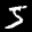

torch.Size([3, 32, 32])


In [12]:
batch_size_train = 256
batch_size_test = 256
batch_size_wm = 64

trainset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/train/', transform=transform_train)
testset = datasets.ImageFolder('./data/CIFAR10_8020/test', transform=transform_test)
# valset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/val/', transform=transform_test)
watermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_random/', transform=transform_test)
advwatermarkset = datasets.ImageFolder('./data/CIFAR10_8020/with_trigger/trigger_adv/', transform=transform_test)
unrelatedset = watermark_unrelated(count=100)
unrl_mixset = torch.utils.data.ConcatDataset((trainset,unrelatedset))
adv_mixset = torch.utils.data.ConcatDataset((trainset,advwatermarkset))
rand_mixset = torch.utils.data.ConcatDataset((trainset,watermarkset))

testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size_test, shuffle=False, num_workers=8)

#valloader = torch.utils.data.DataLoader(
#    valset, batch_size=batch_size_test, shuffle=False, num_workers=8)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

wmloader = torch.utils.data.DataLoader(
    watermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
unrelatedloader = torch.utils.data.DataLoader(
    unrelatedset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
advwmloader = torch.utils.data.DataLoader(
    advwatermarkset, batch_size=batch_size_wm, shuffle=True, num_workers=8, drop_last=False)
unrl_mix_loader = torch.utils.data.DataLoader(
    unrl_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)
adv_mix_loader = torch.utils.data.DataLoader(
    adv_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)
rand_mix_loader = torch.utils.data.DataLoader(
    rand_mixset, batch_size=batch_size_train, shuffle=True, num_workers=8, drop_last=False)

Random Label

In [13]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    rand_mix_loader,
    wmloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_rand_lr0.01',
    epochs=100,
    warmup_epochs=10
)

Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.46it/s]
/home/cysren/anaconda3/envs/wm/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:163: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 0
Train: Train acc 42.38380809595203 | WM acc 0.0
Tests: WM acc 5.0 | WM train avg acc 10.77 | Test acc 54.52
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 1
Train: Train acc 59.85257371314343 | WM acc 0.0
Tests: WM acc 6.0 | WM train avg acc 9.84 | Test acc 60.42999999999999
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 2
Train: Train acc 68.38830584707645 | WM acc 0.0
Tests: WM acc 6.0 | WM train avg acc 10.38 | Test acc 65.72
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:20<00:00,  7.50it/s]


Epoch 3
Train: Train acc 73.53323338330836 | WM acc 0.0
Tests: WM acc 8.0 | WM train avg acc 10.06 | Test acc 72.86
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 4
Train: Train acc 76.20689655172413 | WM acc 0.0
Tests: WM acc 3.0 | WM train avg acc 10.0 | Test acc 73.2
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 5
Train: Train acc 78.49825087456271 | WM acc 0.0
Tests: WM acc 6.0 | WM train avg acc 9.95 | Test acc 73.95
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.97it/s]


Epoch 6
Train: Train acc 80.19490254872564 | WM acc 0.0
Tests: WM acc 14.000000000000002 | WM train avg acc 10.15 | Test acc 75.87
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 7
Train: Train acc 81.111944027986 | WM acc 0.0
Tests: WM acc 18.0 | WM train avg acc 10.34 | Test acc 78.97
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 8
Train: Train acc 82.74112943528236 | WM acc 0.0
Tests: WM acc 16.0 | WM train avg acc 9.51 | Test acc 77.11
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 9
Train: Train acc 83.29085457271364 | WM acc 0.0
Tests: WM acc 28.000000000000004 | WM train avg acc 10.3 | Test acc 80.13
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.59it/s]


Epoch 10
Train: Train acc 84.52023988005996 | WM acc 0.0
Tests: WM acc 24.0 | WM train avg acc 10.08 | Test acc 80.23
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 11
Train: Train acc 84.26036981509245 | WM acc 7.000000000000001
Tests: WM acc 28.000000000000004 | WM train avg acc 9.78 | Test acc 79.86
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 12
Train: Train acc 85.3848075962019 | WM acc 13.0
Tests: WM acc 34.0 | WM train avg acc 10.15 | Test acc 78.08
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 13
Train: Train acc 86.08945527236381 | WM acc 14.000000000000002
Tests: WM acc 50.0 | WM train avg acc 10.24 | Test acc 81.15
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 14
Train: Train acc 86.98900549725137 | WM acc 6.0
Tests: WM acc 59.0 | WM train avg acc 10.02 | Test acc 81.12
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 15
Train: Train acc 87.59370314842579 | WM acc 14.000000000000002
Tests: WM acc 61.0 | WM train avg acc 9.76 | Test acc 81.46
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 16
Train: Train acc 88.54572713643178 | WM acc 13.0
Tests: WM acc 74.0 | WM train avg acc 9.72 | Test acc 82.66
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 17
Train: Train acc 89.09295352323838 | WM acc 13.0
Tests: WM acc 73.0 | WM train avg acc 10.16 | Test acc 81.81
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 18
Train: Train acc 89.60519740129935 | WM acc 12.0
Tests: WM acc 59.0 | WM train avg acc 10.01 | Test acc 79.05
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 19
Train: Train acc 89.99250374812594 | WM acc 10.0
Tests: WM acc 67.0 | WM train avg acc 9.87 | Test acc 80.28999999999999
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 20
Train: Train acc 90.1799100449775 | WM acc 6.0
Tests: WM acc 81.0 | WM train avg acc 9.89 | Test acc 83.52000000000001
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 21
Train: Train acc 90.85957021489254 | WM acc 12.0
Tests: WM acc 75.0 | WM train avg acc 10.11 | Test acc 82.45
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 22
Train: Train acc 91.28935532233882 | WM acc 11.0
Tests: WM acc 81.0 | WM train avg acc 9.81 | Test acc 84.34
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 23
Train: Train acc 91.37931034482759 | WM acc 12.0
Tests: WM acc 80.0 | WM train avg acc 10.18 | Test acc 83.85000000000001
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 24
Train: Train acc 92.14142928535732 | WM acc 13.0
Tests: WM acc 86.0 | WM train avg acc 10.01 | Test acc 84.16
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.68it/s]


Epoch 25
Train: Train acc 92.56621689155422 | WM acc 12.0
Tests: WM acc 93.0 | WM train avg acc 10.52 | Test acc 83.94
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.68it/s]


Epoch 26
Train: Train acc 92.87856071964018 | WM acc 9.0
Tests: WM acc 82.0 | WM train avg acc 10.26 | Test acc 84.3
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.68it/s]


Epoch 27
Train: Train acc 93.38830584707645 | WM acc 13.0
Tests: WM acc 84.0 | WM train avg acc 10.32 | Test acc 84.14
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.68it/s]


Epoch 28
Train: Train acc 93.70064967516242 | WM acc 8.0
Tests: WM acc 82.0 | WM train avg acc 10.07 | Test acc 84.67
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.69it/s]


Epoch 29
Train: Train acc 93.848075962019 | WM acc 9.0
Tests: WM acc 90.0 | WM train avg acc 10.0 | Test acc 84.50999999999999
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.73it/s]


Epoch 30
Train: Train acc 94.66016991504247 | WM acc 10.0
Tests: WM acc 91.0 | WM train avg acc 9.75 | Test acc 85.33
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 31
Train: Train acc 96.87906046976512 | WM acc 5.0
Tests: WM acc 100.0 | WM train avg acc 10.34 | Test acc 87.97
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.55it/s]


Epoch 32
Train: Train acc 97.66116941529236 | WM acc 6.0
Tests: WM acc 100.0 | WM train avg acc 10.06 | Test acc 87.9
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:24<00:00,  6.47it/s]


Epoch 33
Train: Train acc 97.83108445777111 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 10.96 | Test acc 88.02
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:18<00:00,  8.43it/s]


Epoch 34
Train: Train acc 98.12843578210895 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 10.46 | Test acc 87.96000000000001
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:14<00:00, 10.48it/s]


Epoch 35
Train: Train acc 98.40579710144928 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 10.31 | Test acc 88.09
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.43it/s]


Epoch 36
Train: Train acc 98.29585207396302 | WM acc 14.000000000000002
Tests: WM acc 100.0 | WM train avg acc 9.75 | Test acc 88.0
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:16<00:00,  9.39it/s]


Epoch 37
Train: Train acc 98.37581209395302 | WM acc 10.0
Tests: WM acc 100.0 | WM train avg acc 9.91 | Test acc 88.01
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  7.09it/s]


Epoch 38
Train: Train acc 98.62068965517241 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 9.99 | Test acc 88.2
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.89it/s]


Epoch 39
Train: Train acc 98.6606696651674 | WM acc 14.000000000000002
Tests: WM acc 100.0 | WM train avg acc 9.97 | Test acc 88.11
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 40
Train: Train acc 98.65567216391804 | WM acc 10.0
Tests: WM acc 100.0 | WM train avg acc 10.1 | Test acc 88.14
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 41
Train: Train acc 98.78810594702648 | WM acc 6.0
Tests: WM acc 100.0 | WM train avg acc 9.88 | Test acc 88.06
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 42
Train: Train acc 98.79060469765118 | WM acc 13.0
Tests: WM acc 100.0 | WM train avg acc 9.88 | Test acc 87.94
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 43
Train: Train acc 98.77061469265367 | WM acc 6.0
Tests: WM acc 100.0 | WM train avg acc 9.9 | Test acc 88.17
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 44
Train: Train acc 98.85307346326837 | WM acc 13.0
Tests: WM acc 100.0 | WM train avg acc 10.36 | Test acc 88.12
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 45
Train: Train acc 98.95052473763118 | WM acc 6.0
Tests: WM acc 100.0 | WM train avg acc 10.19 | Test acc 88.24
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 46
Train: Train acc 98.99300349825087 | WM acc 13.0
Tests: WM acc 100.0 | WM train avg acc 10.11 | Test acc 88.17
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 47
Train: Train acc 99.06296851574213 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 10.14 | Test acc 88.11
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 48
Train: Train acc 99.13543228385807 | WM acc 18.0
Tests: WM acc 100.0 | WM train avg acc 10.17 | Test acc 88.26
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 49
Train: Train acc 99.16041979010495 | WM acc 8.0
Tests: WM acc 100.0 | WM train avg acc 10.15 | Test acc 88.08
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 50
Train: Train acc 99.11544227886057 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 10.46 | Test acc 88.23
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 51
Train: Train acc 99.22288855572215 | WM acc 17.0
Tests: WM acc 100.0 | WM train avg acc 9.95 | Test acc 88.23
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 52
Train: Train acc 99.19290354822589 | WM acc 10.0
Tests: WM acc 100.0 | WM train avg acc 10.44 | Test acc 88.22
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.68it/s]


Epoch 53
Train: Train acc 99.26536731634182 | WM acc 14.000000000000002
Tests: WM acc 100.0 | WM train avg acc 9.86 | Test acc 88.36
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.68it/s]


Epoch 54
Train: Train acc 99.28535732133933 | WM acc 10.0
Tests: WM acc 100.0 | WM train avg acc 10.07 | Test acc 88.17
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.68it/s]


Epoch 55
Train: Train acc 99.29785107446277 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 10.04 | Test acc 88.14
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 56
Train: Train acc 99.32283858070964 | WM acc 7.000000000000001
Tests: WM acc 100.0 | WM train avg acc 10.63 | Test acc 88.03999999999999
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.68it/s]


Epoch 57
Train: Train acc 99.39530234882558 | WM acc 12.0
Tests: WM acc 100.0 | WM train avg acc 10.03 | Test acc 88.35
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.68it/s]


Epoch 58
Train: Train acc 99.40279860069965 | WM acc 10.0
Tests: WM acc 100.0 | WM train avg acc 10.18 | Test acc 88.11
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.70it/s]


Epoch 59
Train: Train acc 99.4527736131934 | WM acc 10.0
Tests: WM acc 100.0 | WM train avg acc 10.12 | Test acc 88.27000000000001
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.60it/s]


Epoch 60
Train: Train acc 99.4127936031984 | WM acc 12.0
Tests: WM acc 100.0 | WM train avg acc 10.34 | Test acc 88.27000000000001
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.84it/s]


Epoch 61
Train: Train acc 99.51024487756122 | WM acc 8.0
Tests: WM acc 100.0 | WM train avg acc 10.53 | Test acc 88.27000000000001
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  6.86it/s]


Epoch 62
Train: Train acc 99.51774112943528 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 10.73 | Test acc 88.25
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:17<00:00,  8.90it/s]


Epoch 63
Train: Train acc 99.49025487256372 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 9.82 | Test acc 88.32
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.37it/s]


Epoch 64
Train: Train acc 99.53273363318341 | WM acc 14.000000000000002
Tests: WM acc 100.0 | WM train avg acc 10.57 | Test acc 88.37
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.44it/s]


Epoch 65
Train: Train acc 99.52773613193403 | WM acc 6.0
Tests: WM acc 100.0 | WM train avg acc 10.61 | Test acc 88.3
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:17<00:00,  8.85it/s]


Epoch 66
Train: Train acc 99.51024487756122 | WM acc 14.000000000000002
Tests: WM acc 100.0 | WM train avg acc 9.97 | Test acc 88.27000000000001
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.72it/s]


Epoch 67
Train: Train acc 99.54522738630685 | WM acc 7.000000000000001
Tests: WM acc 100.0 | WM train avg acc 10.13 | Test acc 88.3
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.76it/s]


Epoch 68
Train: Train acc 99.5352323838081 | WM acc 13.0
Tests: WM acc 100.0 | WM train avg acc 9.93 | Test acc 88.4
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 69
Train: Train acc 99.58520739630184 | WM acc 6.0
Tests: WM acc 100.0 | WM train avg acc 9.73 | Test acc 88.36
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 70
Train: Train acc 99.54522738630685 | WM acc 10.0
Tests: WM acc 100.0 | WM train avg acc 10.46 | Test acc 88.3
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 71
Train: Train acc 99.60519740129935 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 10.32 | Test acc 88.42
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 72
Train: Train acc 99.5752123938031 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 9.72 | Test acc 88.32
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 73
Train: Train acc 99.56271864067966 | WM acc 7.000000000000001
Tests: WM acc 100.0 | WM train avg acc 10.35 | Test acc 88.42
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.32it/s]


Epoch 74
Train: Train acc 99.53773113443279 | WM acc 14.000000000000002
Tests: WM acc 100.0 | WM train avg acc 10.05 | Test acc 88.31
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.32it/s]


Epoch 75
Train: Train acc 99.58020989505248 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 10.04 | Test acc 88.4
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 76
Train: Train acc 99.62768615692154 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 10.25 | Test acc 88.37
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 77
Train: Train acc 99.61019490254873 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 10.4 | Test acc 88.29
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 78
Train: Train acc 99.56021989005497 | WM acc 12.0
Tests: WM acc 100.0 | WM train avg acc 10.34 | Test acc 88.26
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 79
Train: Train acc 99.62268865567216 | WM acc 10.0
Tests: WM acc 100.0 | WM train avg acc 10.37 | Test acc 88.38000000000001
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.32it/s]


Epoch 80
Train: Train acc 99.58770614692654 | WM acc 6.0
Tests: WM acc 100.0 | WM train avg acc 9.88 | Test acc 88.28
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 81
Train: Train acc 99.57271364317842 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 9.93 | Test acc 88.35
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 82
Train: Train acc 99.58270864567716 | WM acc 10.0
Tests: WM acc 100.0 | WM train avg acc 10.49 | Test acc 88.33
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.31it/s]


Epoch 83
Train: Train acc 99.59770114942529 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 10.51 | Test acc 88.34
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.33it/s]


Epoch 84
Train: Train acc 99.62518740629686 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 10.24 | Test acc 88.42999999999999
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 85
Train: Train acc 99.57771114442778 | WM acc 12.0
Tests: WM acc 100.0 | WM train avg acc 10.14 | Test acc 88.37
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.32it/s]


Epoch 86
Train: Train acc 99.60519740129935 | WM acc 6.0
Tests: WM acc 100.0 | WM train avg acc 10.41 | Test acc 88.44999999999999
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:13<00:00, 11.34it/s]


Epoch 87
Train: Train acc 99.60769615192405 | WM acc 7.000000000000001
Tests: WM acc 100.0 | WM train avg acc 10.49 | Test acc 88.39
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:16<00:00,  9.68it/s]


Epoch 88
Train: Train acc 99.6176911544228 | WM acc 12.0
Tests: WM acc 100.0 | WM train avg acc 10.36 | Test acc 88.28
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.54it/s]


Epoch 89
Train: Train acc 99.63018490754622 | WM acc 10.0
Tests: WM acc 100.0 | WM train avg acc 10.28 | Test acc 88.28
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:17<00:00,  8.79it/s]


Epoch 90
Train: Train acc 99.58020989505248 | WM acc 12.0
Tests: WM acc 100.0 | WM train avg acc 10.11 | Test acc 88.32
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 91
Train: Train acc 99.64017991004498 | WM acc 10.0
Tests: WM acc 100.0 | WM train avg acc 10.34 | Test acc 88.31
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 92
Train: Train acc 99.63768115942028 | WM acc 10.0
Tests: WM acc 100.0 | WM train avg acc 10.29 | Test acc 88.31
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 93
Train: Train acc 99.56021989005497 | WM acc 12.0
Tests: WM acc 100.0 | WM train avg acc 10.11 | Test acc 88.44
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 94
Train: Train acc 99.60019990004997 | WM acc 17.0
Tests: WM acc 100.0 | WM train avg acc 10.24 | Test acc 88.31
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 95
Train: Train acc 99.60269865067465 | WM acc 10.0
Tests: WM acc 100.0 | WM train avg acc 10.11 | Test acc 88.42
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 96
Train: Train acc 99.6176911544228 | WM acc 8.0
Tests: WM acc 100.0 | WM train avg acc 10.02 | Test acc 88.18
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 97
Train: Train acc 99.60019990004997 | WM acc 9.0
Tests: WM acc 100.0 | WM train avg acc 9.94 | Test acc 88.28
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 98
Train: Train acc 99.62518740629686 | WM acc 11.0
Tests: WM acc 100.0 | WM train avg acc 10.05 | Test acc 88.29
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 99
Train: Train acc 99.58520739630184 | WM acc 8.0
Tests: WM acc 100.0 | WM train avg acc 10.4 | Test acc 88.33
./models/wm_cifar10_certify_random_8020_rand_lr0.01.pth


Unrelated 

In [14]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    unrl_mix_loader,
    unrelatedloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_unrl_lr0.01',
    epochs=100,
    warmup_epochs=10
)

Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 0
Train: Train acc 42.243878060969514 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 11.02 | Test acc 49.09
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.45it/s]


Epoch 1
Train: Train acc 59.7551224387806 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 9.73 | Test acc 63.21
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 2
Train: Train acc 68.66316841579211 | WM acc 0.0
Tests: WM acc 95.0 | WM train avg acc 6.22 | Test acc 63.12
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 3
Train: Train acc 73.07596201899051 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 12.83 | Test acc 70.91
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  6.02it/s]


Epoch 4
Train: Train acc 76.55172413793103 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 6.91 | Test acc 72.31
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 5
Train: Train acc 78.42828585707147 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 12.02 | Test acc 76.24
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.61it/s]


Epoch 6
Train: Train acc 80.28985507246377 | WM acc 0.0
Tests: WM acc 97.0 | WM train avg acc 11.82 | Test acc 74.92999999999999
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 7
Train: Train acc 81.13943028485757 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 11.25 | Test acc 79.64
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:19<00:00,  8.20it/s]


Epoch 8
Train: Train acc 82.69865067466267 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 10.6 | Test acc 79.84
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 9
Train: Train acc 83.5432283858071 | WM acc 0.0
Tests: WM acc 100.0 | WM train avg acc 7.67 | Test acc 80.67999999999999
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 10
Train: Train acc 84.88255872063968 | WM acc 0.0
Tests: WM acc 65.0 | WM train avg acc 10.55 | Test acc 79.57
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 11
Train: Train acc 72.66366816591704 | WM acc 36.0
Tests: WM acc 98.0 | WM train avg acc 1.0 | Test acc 76.9
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 12
Train: Train acc 79.40779610194902 | WM acc 36.0
Tests: WM acc 100.0 | WM train avg acc 4.75 | Test acc 80.86
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.68it/s]


Epoch 13
Train: Train acc 79.47776111944029 | WM acc 76.0
Tests: WM acc 100.0 | WM train avg acc 4.51 | Test acc 78.48
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 14
Train: Train acc 81.49925037481259 | WM acc 3.0
Tests: WM acc 100.0 | WM train avg acc 13.31 | Test acc 81.33
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.69it/s]


Epoch 15
Train: Train acc 83.95802098950524 | WM acc 36.0
Tests: WM acc 100.0 | WM train avg acc 5.52 | Test acc 80.86
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 16
Train: Train acc 84.93503248375812 | WM acc 64.0
Tests: WM acc 100.0 | WM train avg acc 18.84 | Test acc 82.97
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 17
Train: Train acc 86.55172413793103 | WM acc 36.0
Tests: WM acc 100.0 | WM train avg acc 21.42 | Test acc 81.34
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 18
Train: Train acc 87.58370814592705 | WM acc 21.0
Tests: WM acc 100.0 | WM train avg acc 23.49 | Test acc 83.85000000000001
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 19
Train: Train acc 88.47326336831584 | WM acc 99.0
Tests: WM acc 100.0 | WM train avg acc 24.86 | Test acc 83.05
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 20
Train: Train acc 89.09295352323838 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 27.12 | Test acc 82.67999999999999
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 21
Train: Train acc 89.52523738130934 | WM acc 60.0
Tests: WM acc 100.0 | WM train avg acc 29.24 | Test acc 83.73
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 22
Train: Train acc 89.88505747126436 | WM acc 77.0
Tests: WM acc 97.0 | WM train avg acc 34.73 | Test acc 84.31
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 23
Train: Train acc 90.38730634682659 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 32.76 | Test acc 84.11
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 24
Train: Train acc 91.06946526736631 | WM acc 61.0
Tests: WM acc 100.0 | WM train avg acc 36.52 | Test acc 82.77
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 25
Train: Train acc 91.26936531734134 | WM acc 85.0
Tests: WM acc 100.0 | WM train avg acc 32.07 | Test acc 83.78999999999999
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 26
Train: Train acc 91.84657671164418 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 34.49 | Test acc 85.05
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 27
Train: Train acc 91.85657171414293 | WM acc 83.0
Tests: WM acc 100.0 | WM train avg acc 31.35 | Test acc 84.92
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 28
Train: Train acc 92.49875062468766 | WM acc 99.0
Tests: WM acc 100.0 | WM train avg acc 32.47 | Test acc 85.41
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 29
Train: Train acc 92.84857571214393 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 29.71 | Test acc 83.0
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 30
Train: Train acc 92.46126936531735 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 47.46 | Test acc 83.85000000000001
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 31
Train: Train acc 95.4247876061969 | WM acc 81.0
Tests: WM acc 100.0 | WM train avg acc 30.87 | Test acc 87.22999999999999
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 32
Train: Train acc 96.34432783608196 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 36.01 | Test acc 87.56
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 33
Train: Train acc 96.79410294852573 | WM acc 64.0
Tests: WM acc 100.0 | WM train avg acc 46.23 | Test acc 87.42999999999999
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 34
Train: Train acc 96.87156421789106 | WM acc 66.0
Tests: WM acc 100.0 | WM train avg acc 32.98 | Test acc 87.59
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 35
Train: Train acc 97.06896551724138 | WM acc 99.0
Tests: WM acc 100.0 | WM train avg acc 43.74 | Test acc 87.67
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 36
Train: Train acc 97.29385307346327 | WM acc 36.0
Tests: WM acc 100.0 | WM train avg acc 43.96 | Test acc 87.64999999999999
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 37
Train: Train acc 97.33383308345826 | WM acc 37.0
Tests: WM acc 100.0 | WM train avg acc 36.64 | Test acc 87.68
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 38
Train: Train acc 97.45627186406797 | WM acc 69.0
Tests: WM acc 100.0 | WM train avg acc 42.55 | Test acc 87.77000000000001
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 39
Train: Train acc 97.59370314842579 | WM acc 72.0
Tests: WM acc 100.0 | WM train avg acc 47.85 | Test acc 87.6
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 40
Train: Train acc 97.63618190904548 | WM acc 7.000000000000001
Tests: WM acc 100.0 | WM train avg acc 35.82 | Test acc 87.57000000000001
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 41
Train: Train acc 97.72863568215891 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 32.71 | Test acc 87.68
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 42
Train: Train acc 97.8535732133933 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 44.75 | Test acc 87.71
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 43
Train: Train acc 97.96601699150425 | WM acc 61.0
Tests: WM acc 100.0 | WM train avg acc 35.19 | Test acc 87.55
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 44
Train: Train acc 97.92853573213394 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 30.81 | Test acc 87.77000000000001
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 45
Train: Train acc 98.25587206396801 | WM acc 90.0
Tests: WM acc 100.0 | WM train avg acc 38.81 | Test acc 87.69
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 46
Train: Train acc 98.13593203398301 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 45.8 | Test acc 87.53999999999999
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 47
Train: Train acc 98.16341829085458 | WM acc 79.0
Tests: WM acc 100.0 | WM train avg acc 40.78 | Test acc 87.71
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 48
Train: Train acc 98.24587706146927 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 39.76 | Test acc 87.72999999999999
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 49
Train: Train acc 98.3008495752124 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 44.47 | Test acc 87.67
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 50
Train: Train acc 98.34582708645677 | WM acc 90.0
Tests: WM acc 100.0 | WM train avg acc 48.99 | Test acc 87.72999999999999
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 51
Train: Train acc 98.5832083958021 | WM acc 67.0
Tests: WM acc 100.0 | WM train avg acc 48.17 | Test acc 87.83999999999999
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 52
Train: Train acc 98.51824087956021 | WM acc 64.0
Tests: WM acc 100.0 | WM train avg acc 43.7 | Test acc 87.89
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 53
Train: Train acc 98.51324337831085 | WM acc 80.0
Tests: WM acc 100.0 | WM train avg acc 44.79 | Test acc 87.67
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.61it/s]


Epoch 54
Train: Train acc 98.58820589705147 | WM acc 42.0
Tests: WM acc 100.0 | WM train avg acc 35.49 | Test acc 87.68
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 55
Train: Train acc 98.67566216891555 | WM acc 99.0
Tests: WM acc 100.0 | WM train avg acc 46.41 | Test acc 87.72999999999999
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 56
Train: Train acc 98.64817591204398 | WM acc 64.0
Tests: WM acc 100.0 | WM train avg acc 43.38 | Test acc 87.83999999999999
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.61it/s]


Epoch 57
Train: Train acc 98.69065467266367 | WM acc 54.0
Tests: WM acc 100.0 | WM train avg acc 40.76 | Test acc 87.61
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 58
Train: Train acc 98.7856071964018 | WM acc 80.0
Tests: WM acc 100.0 | WM train avg acc 40.5 | Test acc 87.72
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 59
Train: Train acc 98.88305847076462 | WM acc 93.0
Tests: WM acc 100.0 | WM train avg acc 44.89 | Test acc 87.77000000000001
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 60
Train: Train acc 98.77561219390304 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 50.08 | Test acc 87.78
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 61
Train: Train acc 98.98800599700151 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 36.41 | Test acc 87.78
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 62
Train: Train acc 99.08045977011494 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 46.26 | Test acc 87.83999999999999
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 63
Train: Train acc 99.06546726636681 | WM acc 33.0
Tests: WM acc 100.0 | WM train avg acc 45.22 | Test acc 87.81
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 64
Train: Train acc 99.06296851574213 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 37.3 | Test acc 87.8
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 65
Train: Train acc 99.08295852073962 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 46.9 | Test acc 87.85
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 66
Train: Train acc 99.05547226386805 | WM acc 73.0
Tests: WM acc 100.0 | WM train avg acc 36.7 | Test acc 87.88
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 67
Train: Train acc 99.1479260369815 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 46.12 | Test acc 87.87
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 68
Train: Train acc 99.12543728135932 | WM acc 86.0
Tests: WM acc 100.0 | WM train avg acc 46.61 | Test acc 87.78
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 69
Train: Train acc 99.14542728635682 | WM acc 64.0
Tests: WM acc 100.0 | WM train avg acc 32.7 | Test acc 87.83
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 70
Train: Train acc 99.11794102948525 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 34.07 | Test acc 87.8
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 71
Train: Train acc 99.1479260369815 | WM acc 36.0
Tests: WM acc 100.0 | WM train avg acc 48.0 | Test acc 87.91
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 72
Train: Train acc 99.10044977511244 | WM acc 59.0
Tests: WM acc 100.0 | WM train avg acc 39.78 | Test acc 87.8
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 73
Train: Train acc 99.19040479760119 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 42.39 | Test acc 87.87
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 74
Train: Train acc 99.1504247876062 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 29.71 | Test acc 87.76
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 75
Train: Train acc 99.11294352823589 | WM acc 36.0
Tests: WM acc 100.0 | WM train avg acc 33.33 | Test acc 87.72999999999999
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 76
Train: Train acc 99.22538730634682 | WM acc 73.0
Tests: WM acc 100.0 | WM train avg acc 39.99 | Test acc 87.6
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 77
Train: Train acc 99.24037981009495 | WM acc 85.0
Tests: WM acc 100.0 | WM train avg acc 45.03 | Test acc 87.72
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 78
Train: Train acc 99.19290354822589 | WM acc 72.0
Tests: WM acc 100.0 | WM train avg acc 42.97 | Test acc 87.82
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 79
Train: Train acc 99.13293353323338 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 45.68 | Test acc 87.89
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 80
Train: Train acc 99.19040479760119 | WM acc 64.0
Tests: WM acc 100.0 | WM train avg acc 41.84 | Test acc 87.79
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 81
Train: Train acc 99.20539730134934 | WM acc 99.0
Tests: WM acc 100.0 | WM train avg acc 45.0 | Test acc 87.75
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 82
Train: Train acc 99.25287356321839 | WM acc 40.0
Tests: WM acc 100.0 | WM train avg acc 46.31 | Test acc 87.75
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 83
Train: Train acc 99.22038980509745 | WM acc 98.0
Tests: WM acc 100.0 | WM train avg acc 44.19 | Test acc 87.86
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 84
Train: Train acc 99.18790604697651 | WM acc 36.0
Tests: WM acc 100.0 | WM train avg acc 35.47 | Test acc 87.87
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 85
Train: Train acc 99.19040479760119 | WM acc 39.0
Tests: WM acc 100.0 | WM train avg acc 45.66 | Test acc 87.83999999999999
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.62it/s]


Epoch 86
Train: Train acc 99.15292353823088 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 43.13 | Test acc 87.75
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 87
Train: Train acc 99.1704147926037 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 48.24 | Test acc 87.81
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.33it/s]


Epoch 88
Train: Train acc 99.2128935532234 | WM acc 68.0
Tests: WM acc 100.0 | WM train avg acc 36.45 | Test acc 87.78
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:28<00:00,  5.54it/s]


Epoch 89
Train: Train acc 99.20539730134934 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 44.05 | Test acc 87.86
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:15<00:00,  9.93it/s]


Epoch 90
Train: Train acc 99.25787106446776 | WM acc 94.0
Tests: WM acc 100.0 | WM train avg acc 51.52 | Test acc 87.81
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:18<00:00,  8.37it/s]


Epoch 91
Train: Train acc 99.28535732133933 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 48.28 | Test acc 87.86
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:20<00:00,  7.70it/s]


Epoch 92
Train: Train acc 99.28535732133933 | WM acc 80.0
Tests: WM acc 100.0 | WM train avg acc 36.65 | Test acc 87.83
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:22<00:00,  7.05it/s]


Epoch 93
Train: Train acc 99.3103448275862 | WM acc 14.000000000000002
Tests: WM acc 100.0 | WM train avg acc 35.35 | Test acc 87.8
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:23<00:00,  6.61it/s]


Epoch 94
Train: Train acc 99.24537731134433 | WM acc 78.0
Tests: WM acc 100.0 | WM train avg acc 45.49 | Test acc 87.83
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:25<00:00,  6.25it/s]


Epoch 95
Train: Train acc 99.23538230884557 | WM acc 53.0
Tests: WM acc 100.0 | WM train avg acc 38.96 | Test acc 87.81
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:26<00:00,  5.93it/s]


Epoch 96
Train: Train acc 99.22038980509745 | WM acc 45.0
Tests: WM acc 100.0 | WM train avg acc 34.54 | Test acc 87.9
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.79it/s]


Epoch 97
Train: Train acc 99.22288855572215 | WM acc 42.0
Tests: WM acc 100.0 | WM train avg acc 38.95 | Test acc 87.71
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 98
Train: Train acc 99.19790104947526 | WM acc 62.0
Tests: WM acc 100.0 | WM train avg acc 41.33 | Test acc 87.86
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 99
Train: Train acc 99.20539730134934 | WM acc 100.0
Tests: WM acc 100.0 | WM train avg acc 33.19 | Test acc 87.83
./models/wm_cifar10_certify_random_8020_unrl_lr0.01.pth


Adversarial

In [ ]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    adv_mix_loader,
    advwmloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_adv_lr0.01',
    epochs=100,
    warmup_epochs=10
)

Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 0
Train: Train acc 41.98650674662668 | WM acc 0.0
Tests: WM acc 3.0 | WM train avg acc 9.98 | Test acc 55.24
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 1
Train: Train acc 60.23238380809596 | WM acc 0.0
Tests: WM acc 12.0 | WM train avg acc 9.4 | Test acc 59.08
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:18<00:00,  8.39it/s]


Epoch 2
Train: Train acc 67.3688155922039 | WM acc 0.0
Tests: WM acc 9.0 | WM train avg acc 9.99 | Test acc 68.30000000000001
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.63it/s]


Epoch 3
Train: Train acc 72.82108945527236 | WM acc 0.0
Tests: WM acc 3.0 | WM train avg acc 9.96 | Test acc 67.67999999999999
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 4
Train: Train acc 75.73213393303348 | WM acc 0.0
Tests: WM acc 6.0 | WM train avg acc 10.43 | Test acc 74.1
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:15<00:00, 10.39it/s]


Epoch 5
Train: Train acc 78.2183908045977 | WM acc 0.0
Tests: WM acc 13.0 | WM train avg acc 10.39 | Test acc 72.65
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.64it/s]


Epoch 6
Train: Train acc 79.92003998000999 | WM acc 0.0
Tests: WM acc 9.0 | WM train avg acc 10.11 | Test acc 73.7
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 7
Train: Train acc 81.56171914042979 | WM acc 0.0
Tests: WM acc 19.0 | WM train avg acc 9.62 | Test acc 76.59
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:19<00:00,  7.88it/s]


Epoch 8
Train: Train acc 82.6111944027986 | WM acc 0.0
Tests: WM acc 17.0 | WM train avg acc 9.98 | Test acc 73.33
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 9
Train: Train acc 83.35082458770616 | WM acc 0.0
Tests: WM acc 31.0 | WM train avg acc 10.25 | Test acc 72.39999999999999
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 10
Train: Train acc 84.53273363318341 | WM acc 0.0
Tests: WM acc 33.0 | WM train avg acc 9.27 | Test acc 79.79
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.65it/s]


Epoch 11
Train: Train acc 84.38530734632683 | WM acc 9.0
Tests: WM acc 52.0 | WM train avg acc 10.34 | Test acc 80.10000000000001
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 12
Train: Train acc 85.01249375312344 | WM acc 12.0
Tests: WM acc 26.0 | WM train avg acc 9.72 | Test acc 77.9
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 13
Train: Train acc 86.32183908045977 | WM acc 5.0
Tests: WM acc 37.0 | WM train avg acc 10.23 | Test acc 79.39
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 14
Train: Train acc 86.92403798100949 | WM acc 7.000000000000001
Tests: WM acc 57.99999999999999 | WM train avg acc 9.59 | Test acc 81.89
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 15
Train: Train acc 87.43878060969516 | WM acc 4.0
Tests: WM acc 76.0 | WM train avg acc 9.95 | Test acc 83.85000000000001
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 16
Train: Train acc 88.16341829085458 | WM acc 14.000000000000002
Tests: WM acc 62.0 | WM train avg acc 11.11 | Test acc 82.71
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 17
Train: Train acc 88.39830084957522 | WM acc 12.0
Tests: WM acc 82.0 | WM train avg acc 10.84 | Test acc 83.65
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 18
Train: Train acc 89.00549725137431 | WM acc 11.0
Tests: WM acc 72.0 | WM train avg acc 10.38 | Test acc 82.46
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 19
Train: Train acc 89.88755622188906 | WM acc 13.0
Tests: WM acc 80.0 | WM train avg acc 9.59 | Test acc 82.39
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 20
Train: Train acc 90.3023488255872 | WM acc 9.0
Tests: WM acc 73.0 | WM train avg acc 10.02 | Test acc 81.74
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 21
Train: Train acc 90.63968015992005 | WM acc 11.0
Tests: WM acc 88.0 | WM train avg acc 10.17 | Test acc 83.61
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 22
Train: Train acc 91.29185407296352 | WM acc 9.0
Tests: WM acc 84.0 | WM train avg acc 10.78 | Test acc 83.58
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 23
Train: Train acc 91.84907546226887 | WM acc 7.000000000000001
Tests: WM acc 93.0 | WM train avg acc 9.99 | Test acc 84.81
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 24
Train: Train acc 91.38680659670165 | WM acc 13.0
Tests: WM acc 86.0 | WM train avg acc 10.6 | Test acc 83.14
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 25
Train: Train acc 92.48375812093953 | WM acc 15.0
Tests: WM acc 86.0 | WM train avg acc 10.47 | Test acc 83.02000000000001
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.67it/s]


Epoch 26
Train: Train acc 93.10594702648676 | WM acc 8.0
Tests: WM acc 93.0 | WM train avg acc 10.41 | Test acc 84.78999999999999
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Normal training: 100%|█████████████████████████████████████████████████████████████| 157/157 [00:27<00:00,  5.66it/s]


Epoch 27
Train: Train acc 93.20089955022489 | WM acc 11.0
Tests: WM acc 95.0 | WM train avg acc 9.87 | Test acc 84.39999999999999
./models/wm_cifar10_certify_random_8020_adv_lr0.01.pth


Robust training:   0%|                                                                         | 0/2 [00:00<?, ?it/s]

LR=0.005

Random Label Uniform Scheme

In [ ]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_rand_lr0.005.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adversarial Sample Uniform Scheme

In [ ]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_adv_lr0.005.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

Unrelated Uniform Scheme

In [ ]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=unrelatedloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_unrl_lr0.005.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader)

Random Label Original Scheme

In [ ]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_rand_lr0.005.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adversarial Sample Original Scheme

In [ ]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_adv_lr0.005.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

Unrelated Original Scheme

In [ ]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=unrelatedloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_unrl_lr0.005.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader)

Random Label

In [ ]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    rand_mix_loader,
    wmloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_rand_lr0.005',
    epochs=100,
    warmup_epochs=10
)

Unrelated 

In [ ]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    unrl_mix_loader,
    unrelatedloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_unrl_lr0.005',
    epochs=100,
    warmup_epochs=10
)

Adversarial

In [ ]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    adv_mix_loader,
    advwmloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_adv_lr0.005',
    epochs=100,
    warmup_epochs=10
)

lr=0.001

Random Label Uniform Scheme

In [ ]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_rand_lr0.001.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adversarial Sample Uniform Scheme

In [ ]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_adv_lr0.001.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

Unrelated Uniform Scheme

In [ ]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=unrelatedloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_unrl_lr0.001.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader)

Random Label Original Scheme

In [ ]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_rand_lr0.001.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adversarial Sample Original Scheme

In [ ]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_adv_lr0.001.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

Unrelated Original Scheme

In [ ]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=unrelatedloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_unrl_lr0.001.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader)

Random Label

In [ ]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    rand_mix_loader,
    wmloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_rand_lr0.001',
    epochs=100,
    warmup_epochs=10
)

Unrelated 

In [ ]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    unrl_mix_loader,
    unrelatedloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_unrl_lr0.001',
    epochs=100,
    warmup_epochs=10
)

Adversarial

In [ ]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    adv_mix_loader,
    advwmloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_adv_lr0.001',
    epochs=100,
    warmup_epochs=10
)

lr=0.0005

Random Label Uniform Scheme

In [ ]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_rand_lr0.0005.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adversarial Sample Uniform Scheme

In [ ]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_adv_lr0.0005.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

Unrelated Uniform Scheme

In [ ]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=unrelatedloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_unrl_lr0.0005.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader)

Random Label Original Scheme

In [ ]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_rand_lr0.0005.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adversarial Sample Original Scheme

In [ ]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_adv_lr0.0005.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

Unrelated Original Scheme

In [ ]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=unrelatedloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_unrl_lr0.0005.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader)

Random Label

In [ ]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    rand_mix_loader,
    wmloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_rand_lr0.0005',
    epochs=100,
    warmup_epochs=10
)

Unrelated 

In [ ]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    unrl_mix_loader,
    unrelatedloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_unrl_lr0.0005',
    epochs=100,
    warmup_epochs=10
)

Adversarial

In [ ]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    adv_mix_loader,
    advwmloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_adv_lr0.0005',
    epochs=100,
    warmup_epochs=10
)

lr=0.0001

Random Label Uniform Scheme

In [ ]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_rand_lr0.0001.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adversarial Sample Uniform Scheme

In [ ]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_adv_lr0.0001.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

Unrelated Uniform Scheme

In [ ]:
# watermark with frozen layers
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
frozen_layers=[net.conv1, net.bn1, net.layer1, net.layer2, net.layer3, net.layer4]
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=unrelatedloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_frozen_8020_unrl_lr0.0001.ckpt', frozen_layers=frozen_layers,
      logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader)

Random Label Original Scheme

In [ ]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=wmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_rand_lr0.0001.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=wmloader)

Adversarial Sample Original Scheme

In [ ]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=advwmloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_adv_lr0.0001.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=advwmloader)

Unrelated Original Scheme

In [ ]:
# normal watermark
net = ResNet18()
logcmt = f"resnet18_8020_trigger_finetune"
net.load_state_dict(torch.load('checkpoints/resnet18_8020.ckpt'))
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, verbose=True)
trainer = Trainer(net, criterion, optimizer, train_loader=trainloader, trigger_loader=unrelatedloader, use_trigger=True, scheduler=scheduler)
evaluator = Evaluator(net, criterion)
train(trainer, evaluator, testloader, 80, 'checkpoints/resnet18_wm_8020_unrl_lr0.0001.ckpt',
      logdir='./runs', logcmt=logcmt, trigger_loader=unrelatedloader)

Random Label

In [ ]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    rand_mix_loader,
    wmloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_rand_lr0.0001',
    epochs=100,
    warmup_epochs=10
)

Unrelated 

In [ ]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    unrl_mix_loader,
    unrelatedloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_unrl_lr0.0001',
    epochs=100,
    warmup_epochs=10
)

Adversarial

In [ ]:
net = ResNet18()
optimizer = torch.optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

train_certified_wm(
    net,
    adv_mix_loader,
    advwmloader,
    testloader,
    optimizer,
    scheduler,
    cert_type='random_8020_adv_lr0.0001',
    epochs=100,
    warmup_epochs=10
)